In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Jul 21 17:54:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 26%   33C    P0    31W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   79C    P0   130W / 250W |   1913MiB / 16280MiB |     95%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mjp_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mjp_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mjp_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mjp_07July2020 import All_CNN6Layer_E as ModelE
from model.models_mjp_07July2020 import All_CNN6Layer_F as ModelF

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 1000, 1e-3, 1420)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 13.91 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 12.35 s
Constructing 160000 event dataset took 4.87 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 3.027 s
Constructing 9984 event dataset took 0.1257 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelG()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/7d6cd2dc9c61451abdbe7fb8591313d3/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 6.0 parameter layers to update in the current model, 6.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN6Layer_F(
  (conv1): Conv1d(1, 10, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(5, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(5, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


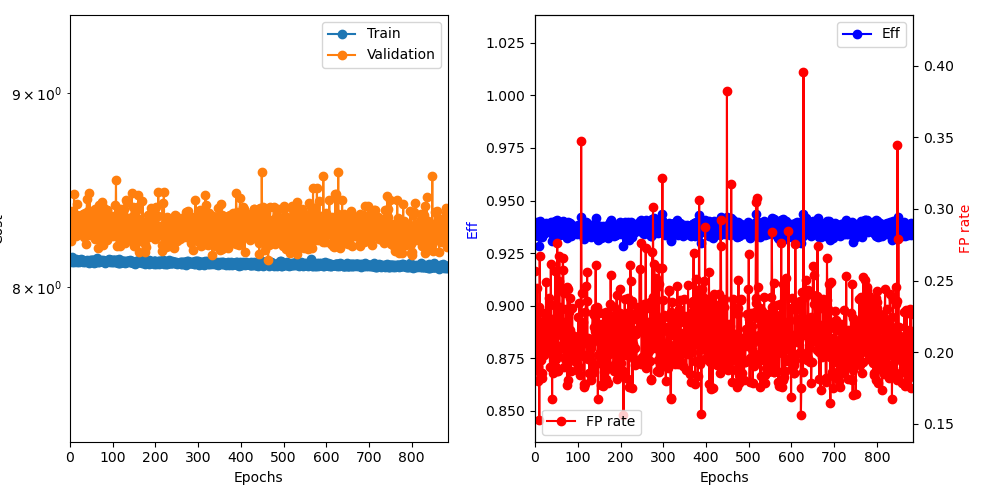

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [ ]:
print('for model: ', model)   
run_name = 'ACNN F Continued'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

for model:  All_CNN6Layer_F(
  (conv1): Conv1d(1, 10, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(5, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(5, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)
epoch_start 1420
batch_size 128
epochs 1000
lr 0.001
Number of batches: train = 1250, val = 78


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 1420: train=8.126, val=8.31623, took 26.807 s
  Validation Found 51150 of 54504, added 2566 (eff 93.85%) (0.257 FP/event)


Epoch 1421: train=8.13025, val=8.34042, took 25.774 s
  Validation Found 51058 of 54504, added 2085 (eff 93.68%) (0.209 FP/event)


Epoch 1422: train=8.129, val=8.22467, took 25.796 s
  Validation Found 51125 of 54504, added 2181 (eff 93.80%) (0.218 FP/event)


Epoch 1423: train=8.13532, val=8.25763, took 26.101 s
  Validation Found 51108 of 54504, added 2237 (eff 93.77%) (0.224 FP/event)


Epoch 1424: train=8.12212, val=8.30453, took 25.695 s
  Validation Found 50914 of 54504, added 1870 (eff 93.41%) (0.187 FP/event)


Epoch 1425: train=8.12879, val=8.25725, took 26.063 s
  Validation Found 51233 of 54504, added 2441 (eff 94.00%) (0.244 FP/event)


Epoch 1426: train=8.14566, val=8.37923, took 25.929 s
  Validation Found 50850 of 54504, added 1796 (eff 93.30%) (0.18 FP/event)


Epoch 1427: train=8.12678, val=8.34853, took 25.855 s
  Validation Found 50888 of 54504, added 1891 (eff 93.37%) (0.189 FP/event)


Epoch 1428: train=8.13207, val=8.32021, took 25.978 s
  Validation Found 51076 of 54504, added 2172 (eff 93.71%) (0.218 FP/event)


Epoch 1429: train=8.13857, val=8.28438, took 25.748 s
  Validation Found 51173 of 54504, added 2315 (eff 93.89%) (0.232 FP/event)


Epoch 1430: train=8.12078, val=8.46761, took 25.641 s
  Validation Found 50592 of 54504, added 1525 (eff 92.82%) (0.153 FP/event)


Epoch 1431: train=8.13055, val=8.29049, took 25.641 s
  Validation Found 51239 of 54504, added 2667 (eff 94.01%) (0.267 FP/event)


Epoch 1432: train=8.13352, val=8.28926, took 26.007 s
  Validation Found 51014 of 54504, added 2014 (eff 93.60%) (0.202 FP/event)


Epoch 1433: train=8.12943, val=8.28763, took 25.82 s
  Validation Found 50973 of 54504, added 2207 (eff 93.52%) (0.221 FP/event)


Epoch 1434: train=8.13019, val=8.31443, took 25.823 s
  Validation Found 50986 of 54504, added 1945 (eff 93.55%) (0.195 FP/event)


Epoch 1435: train=8.13744, val=8.2538, took 25.893 s
  Validation Found 51062 of 54504, added 2197 (eff 93.68%) (0.22 FP/event)


Epoch 1436: train=8.12129, val=8.41653, took 25.887 s
  Validation Found 50835 of 54504, added 1814 (eff 93.27%) (0.182 FP/event)


Epoch 1437: train=8.12714, val=8.35605, took 25.509 s
  Validation Found 50891 of 54504, added 1849 (eff 93.37%) (0.185 FP/event)


Epoch 1438: train=8.12501, val=8.33087, took 25.967 s
  Validation Found 50985 of 54504, added 2012 (eff 93.54%) (0.202 FP/event)


Epoch 1439: train=8.1318, val=8.26142, took 25.852 s
  Validation Found 51139 of 54504, added 2272 (eff 93.83%) (0.228 FP/event)


Epoch 1440: train=8.12922, val=8.27315, took 25.72 s
  Validation Found 51091 of 54504, added 2165 (eff 93.74%) (0.217 FP/event)


Epoch 1441: train=8.12367, val=8.33083, took 25.785 s
  Validation Found 50926 of 54504, added 1979 (eff 93.44%) (0.198 FP/event)


Epoch 1442: train=8.12832, val=8.27085, took 25.897 s
  Validation Found 51024 of 54504, added 2035 (eff 93.62%) (0.204 FP/event)


Epoch 1443: train=8.13383, val=8.32707, took 25.86 s
  Validation Found 50928 of 54504, added 1991 (eff 93.44%) (0.199 FP/event)


Epoch 1444: train=8.12708, val=8.28294, took 25.768 s
  Validation Found 51030 of 54504, added 2046 (eff 93.63%) (0.205 FP/event)


Epoch 1445: train=8.13418, val=8.33124, took 25.707 s
  Validation Found 51127 of 54504, added 2133 (eff 93.80%) (0.214 FP/event)


Epoch 1446: train=8.13683, val=8.34205, took 25.928 s
  Validation Found 51186 of 54504, added 2488 (eff 93.91%) (0.249 FP/event)


Epoch 1447: train=8.13427, val=8.32716, took 26.025 s
  Validation Found 51083 of 54504, added 2221 (eff 93.72%) (0.222 FP/event)


Epoch 1448: train=8.12821, val=8.32418, took 25.671 s
  Validation Found 51018 of 54504, added 2050 (eff 93.60%) (0.205 FP/event)


Epoch 1449: train=8.12935, val=8.35722, took 25.869 s
  Validation Found 51141 of 54504, added 2148 (eff 93.83%) (0.215 FP/event)


Epoch 1450: train=8.12849, val=8.36066, took 25.682 s
  Validation Found 50999 of 54504, added 2118 (eff 93.57%) (0.212 FP/event)


Epoch 1451: train=8.13024, val=8.26628, took 25.983 s
  Validation Found 51129 of 54504, added 2183 (eff 93.81%) (0.219 FP/event)


Epoch 1452: train=8.12248, val=8.2694, took 25.872 s
  Validation Found 51155 of 54504, added 2373 (eff 93.86%) (0.238 FP/event)


Epoch 1453: train=8.1272, val=8.31093, took 25.722 s
  Validation Found 50998 of 54504, added 2094 (eff 93.57%) (0.21 FP/event)


Epoch 1454: train=8.12808, val=8.24905, took 25.839 s
  Validation Found 51061 of 54504, added 2069 (eff 93.68%) (0.207 FP/event)


Epoch 1455: train=8.12926, val=8.34025, took 25.682 s
  Validation Found 50960 of 54504, added 1895 (eff 93.50%) (0.19 FP/event)


Epoch 1456: train=8.1219, val=8.36897, took 25.744 s
  Validation Found 50997 of 54504, added 2087 (eff 93.57%) (0.209 FP/event)


Epoch 1457: train=8.12527, val=8.21181, took 25.768 s
  Validation Found 51228 of 54504, added 2608 (eff 93.99%) (0.261 FP/event)


Epoch 1458: train=8.12589, val=8.32172, took 25.769 s
  Validation Found 51033 of 54504, added 2127 (eff 93.63%) (0.213 FP/event)


Epoch 1459: train=8.12938, val=8.26839, took 25.763 s
  Validation Found 51178 of 54504, added 2228 (eff 93.90%) (0.223 FP/event)


Epoch 1460: train=8.12516, val=8.43918, took 25.772 s
  Validation Found 50724 of 54504, added 1667 (eff 93.06%) (0.167 FP/event)


Epoch 1461: train=8.13054, val=8.26277, took 25.776 s
  Validation Found 51099 of 54504, added 2119 (eff 93.75%) (0.212 FP/event)


Epoch 1462: train=8.12402, val=8.37762, took 25.773 s
  Validation Found 50894 of 54504, added 1854 (eff 93.38%) (0.186 FP/event)


Epoch 1463: train=8.1255, val=8.33929, took 25.761 s
  Validation Found 50903 of 54504, added 1872 (eff 93.39%) (0.187 FP/event)


Epoch 1464: train=8.12822, val=8.28058, took 25.969 s
  Validation Found 51161 of 54504, added 2327 (eff 93.87%) (0.233 FP/event)


Epoch 1465: train=8.12207, val=8.26303, took 25.817 s
  Validation Found 51114 of 54504, added 2217 (eff 93.78%) (0.222 FP/event)


Epoch 1466: train=8.11978, val=8.46837, took 25.806 s
  Validation Found 50811 of 54504, added 1865 (eff 93.22%) (0.187 FP/event)


Epoch 1467: train=8.13081, val=8.25915, took 26.207 s
  Validation Found 51246 of 54504, added 2561 (eff 94.02%) (0.256 FP/event)


Epoch 1468: train=8.12791, val=8.32126, took 25.809 s
  Validation Found 50912 of 54504, added 1892 (eff 93.41%) (0.189 FP/event)


Epoch 1469: train=8.12698, val=8.34366, took 25.815 s
  Validation Found 50950 of 54504, added 1952 (eff 93.48%) (0.195 FP/event)


Epoch 1470: train=8.13191, val=8.33715, took 26.002 s
  Validation Found 50873 of 54504, added 1881 (eff 93.34%) (0.188 FP/event)


Epoch 1471: train=8.1271, val=8.35816, took 25.819 s
  Validation Found 50892 of 54504, added 1866 (eff 93.37%) (0.187 FP/event)


Epoch 1472: train=8.12159, val=8.25576, took 25.872 s
  Validation Found 51264 of 54504, added 2758 (eff 94.06%) (0.276 FP/event)


Epoch 1473: train=8.13217, val=8.37839, took 25.839 s
  Validation Found 50870 of 54504, added 1863 (eff 93.33%) (0.187 FP/event)


Epoch 1474: train=8.13257, val=8.30788, took 25.835 s
  Validation Found 51016 of 54504, added 1974 (eff 93.60%) (0.198 FP/event)


Epoch 1475: train=8.13247, val=8.28346, took 25.819 s
  Validation Found 51027 of 54504, added 2038 (eff 93.62%) (0.204 FP/event)


Epoch 1476: train=8.11971, val=8.26466, took 25.911 s
  Validation Found 51175 of 54504, added 2491 (eff 93.89%) (0.249 FP/event)


Epoch 1477: train=8.1261, val=8.35829, took 25.962 s
  Validation Found 51140 of 54504, added 2666 (eff 93.83%) (0.267 FP/event)


Epoch 1478: train=8.12389, val=8.36212, took 25.823 s
  Validation Found 51069 of 54504, added 2188 (eff 93.70%) (0.219 FP/event)


Epoch 1479: train=8.12438, val=8.23795, took 25.752 s
  Validation Found 51143 of 54504, added 2315 (eff 93.83%) (0.232 FP/event)


Epoch 1480: train=8.12512, val=8.38854, took 25.753 s
  Validation Found 51045 of 54504, added 2119 (eff 93.65%) (0.212 FP/event)


Epoch 1481: train=8.12412, val=8.34847, took 25.719 s
  Validation Found 51006 of 54504, added 2155 (eff 93.58%) (0.216 FP/event)


Epoch 1482: train=8.12546, val=8.36083, took 25.801 s
  Validation Found 50953 of 54504, added 2027 (eff 93.48%) (0.203 FP/event)


Epoch 1483: train=8.14299, val=8.36278, took 25.679 s
  Validation Found 51070 of 54504, added 2186 (eff 93.70%) (0.219 FP/event)


Epoch 1484: train=8.12868, val=8.34664, took 25.796 s
  Validation Found 51088 of 54504, added 2434 (eff 93.73%) (0.244 FP/event)


Epoch 1485: train=8.12789, val=8.2421, took 25.807 s
  Validation Found 51193 of 54504, added 2655 (eff 93.93%) (0.266 FP/event)


Epoch 1486: train=8.12656, val=8.25778, took 25.83 s
  Validation Found 51252 of 54504, added 2568 (eff 94.03%) (0.257 FP/event)


Epoch 1487: train=8.12363, val=8.19424, took 25.856 s
  Validation Found 51215 of 54504, added 2409 (eff 93.97%) (0.241 FP/event)


Epoch 1488: train=8.12686, val=8.40758, took 25.886 s
  Validation Found 50892 of 54504, added 1890 (eff 93.37%) (0.189 FP/event)


Epoch 1489: train=8.12426, val=8.29271, took 25.813 s
  Validation Found 51083 of 54504, added 2139 (eff 93.72%) (0.214 FP/event)


Epoch 1490: train=8.12911, val=8.35183, took 25.954 s
  Validation Found 50910 of 54504, added 1951 (eff 93.41%) (0.195 FP/event)


Epoch 1491: train=8.12516, val=8.23271, took 25.819 s
  Validation Found 51112 of 54504, added 2121 (eff 93.78%) (0.212 FP/event)


Epoch 1492: train=8.1293, val=8.40017, took 26.241 s
  Validation Found 51015 of 54504, added 2105 (eff 93.60%) (0.211 FP/event)


Epoch 1493: train=8.12928, val=8.25591, took 25.915 s
  Validation Found 51173 of 54504, added 2295 (eff 93.89%) (0.23 FP/event)


Epoch 1494: train=8.13065, val=8.31567, took 25.814 s
  Validation Found 51025 of 54504, added 2211 (eff 93.62%) (0.221 FP/event)


Epoch 1495: train=8.12673, val=8.42377, took 25.896 s
  Validation Found 50806 of 54504, added 1769 (eff 93.22%) (0.177 FP/event)


Epoch 1496: train=8.12851, val=8.31137, took 25.869 s
  Validation Found 51157 of 54504, added 2451 (eff 93.86%) (0.245 FP/event)


Epoch 1497: train=8.12801, val=8.20525, took 25.855 s
  Validation Found 51225 of 54504, added 2436 (eff 93.98%) (0.244 FP/event)


Epoch 1498: train=8.13263, val=8.3974, took 25.843 s
  Validation Found 50858 of 54504, added 1801 (eff 93.31%) (0.18 FP/event)


Epoch 1499: train=8.1289, val=8.36258, took 25.694 s
  Validation Found 51053 of 54504, added 2277 (eff 93.67%) (0.228 FP/event)


Epoch 1500: train=8.1223, val=8.3593, took 25.757 s
  Validation Found 50936 of 54504, added 1936 (eff 93.45%) (0.194 FP/event)


Epoch 1501: train=8.12498, val=8.2655, took 25.694 s
  Validation Found 51184 of 54504, added 2371 (eff 93.91%) (0.237 FP/event)


Epoch 1502: train=8.12634, val=8.30263, took 25.777 s
  Validation Found 51119 of 54504, added 2152 (eff 93.79%) (0.216 FP/event)


Epoch 1503: train=8.11828, val=8.30804, took 25.763 s
  Validation Found 50990 of 54504, added 1954 (eff 93.55%) (0.196 FP/event)


Epoch 1504: train=8.12632, val=8.3615, took 25.701 s
  Validation Found 50871 of 54504, added 1867 (eff 93.33%) (0.187 FP/event)


Epoch 1505: train=8.12246, val=8.34456, took 25.735 s
  Validation Found 50983 of 54504, added 1961 (eff 93.54%) (0.196 FP/event)


Epoch 1506: train=8.12604, val=8.38253, took 25.693 s
  Validation Found 51041 of 54504, added 2119 (eff 93.65%) (0.212 FP/event)


Epoch 1507: train=8.12637, val=8.23002, took 25.731 s
  Validation Found 51135 of 54504, added 2306 (eff 93.82%) (0.231 FP/event)


Epoch 1508: train=8.12611, val=8.38077, took 25.743 s
  Validation Found 50945 of 54504, added 2025 (eff 93.47%) (0.203 FP/event)


Epoch 1509: train=8.13062, val=8.31987, took 25.778 s
  Validation Found 50992 of 54504, added 2015 (eff 93.56%) (0.202 FP/event)


Epoch 1510: train=8.12919, val=8.25324, took 25.639 s
  Validation Found 51030 of 54504, added 2046 (eff 93.63%) (0.205 FP/event)


Epoch 1511: train=8.13518, val=8.28129, took 25.506 s
  Validation Found 51019 of 54504, added 2073 (eff 93.61%) (0.208 FP/event)


Epoch 1512: train=8.13421, val=8.27715, took 25.516 s
  Validation Found 51030 of 54504, added 2110 (eff 93.63%) (0.211 FP/event)


Epoch 1513: train=8.13159, val=8.26478, took 25.668 s
  Validation Found 50962 of 54504, added 1935 (eff 93.50%) (0.194 FP/event)


Epoch 1514: train=8.13106, val=8.27489, took 25.913 s
  Validation Found 51080 of 54504, added 2057 (eff 93.72%) (0.206 FP/event)


Epoch 1515: train=8.1231, val=8.25217, took 25.791 s
  Validation Found 51045 of 54504, added 2070 (eff 93.65%) (0.207 FP/event)


Epoch 1516: train=8.13414, val=8.31492, took 25.799 s
  Validation Found 50956 of 54504, added 1927 (eff 93.49%) (0.193 FP/event)


Epoch 1517: train=8.12561, val=8.25682, took 25.812 s
  Validation Found 51033 of 54504, added 1987 (eff 93.63%) (0.199 FP/event)


Epoch 1518: train=8.12331, val=8.33037, took 25.809 s
  Validation Found 50943 of 54504, added 1922 (eff 93.47%) (0.192 FP/event)


Epoch 1519: train=8.12737, val=8.35384, took 25.844 s
  Validation Found 50906 of 54504, added 1873 (eff 93.40%) (0.188 FP/event)


Epoch 1520: train=8.1322, val=8.31552, took 25.849 s
  Validation Found 51026 of 54504, added 2045 (eff 93.62%) (0.205 FP/event)


Epoch 1521: train=8.13102, val=8.25363, took 25.819 s
  Validation Found 51147 of 54504, added 2241 (eff 93.84%) (0.224 FP/event)


Epoch 1522: train=8.1236, val=8.29916, took 25.821 s
  Validation Found 51011 of 54504, added 2012 (eff 93.59%) (0.202 FP/event)


Epoch 1523: train=8.12995, val=8.29636, took 26.212 s
  Validation Found 50929 of 54504, added 1895 (eff 93.44%) (0.19 FP/event)


Epoch 1524: train=8.12719, val=8.26499, took 25.863 s
  Validation Found 51120 of 54504, added 2337 (eff 93.79%) (0.234 FP/event)


Epoch 1525: train=8.13052, val=8.29627, took 25.75 s
  Validation Found 50935 of 54504, added 1987 (eff 93.45%) (0.199 FP/event)


Epoch 1526: train=8.12116, val=8.40935, took 25.768 s
  Validation Found 50901 of 54504, added 1836 (eff 93.39%) (0.184 FP/event)


Epoch 1527: train=8.12223, val=8.29054, took 26.084 s
  Validation Found 51107 of 54504, added 2097 (eff 93.77%) (0.21 FP/event)


Epoch 1528: train=8.12575, val=8.54031, took 26.062 s
  Validation Found 51344 of 54504, added 3467 (eff 94.20%) (0.347 FP/event)


Epoch 1529: train=8.13235, val=8.2564, took 25.833 s
  Validation Found 51176 of 54504, added 2410 (eff 93.89%) (0.241 FP/event)


Epoch 1530: train=8.13431, val=8.20226, took 25.909 s
  Validation Found 51082 of 54504, added 2134 (eff 93.72%) (0.214 FP/event)


Epoch 1531: train=8.12603, val=8.31472, took 25.84 s
  Validation Found 51056 of 54504, added 2137 (eff 93.67%) (0.214 FP/event)


Epoch 1532: train=8.11678, val=8.24891, took 26.012 s
  Validation Found 51104 of 54504, added 2206 (eff 93.76%) (0.221 FP/event)


Epoch 1533: train=8.12397, val=8.35439, took 25.871 s
  Validation Found 50984 of 54504, added 1972 (eff 93.54%) (0.197 FP/event)


Epoch 1534: train=8.12447, val=8.38948, took 25.848 s
  Validation Found 50823 of 54504, added 1752 (eff 93.25%) (0.175 FP/event)


Epoch 1535: train=8.1197, val=8.37275, took 25.882 s
  Validation Found 50792 of 54504, added 1777 (eff 93.19%) (0.178 FP/event)


Epoch 1536: train=8.13927, val=8.30167, took 25.85 s
  Validation Found 50865 of 54504, added 1777 (eff 93.32%) (0.178 FP/event)


Epoch 1537: train=8.12075, val=8.28141, took 25.836 s
  Validation Found 51131 of 54504, added 2280 (eff 93.81%) (0.228 FP/event)


Epoch 1538: train=8.11906, val=8.20102, took 25.813 s
  Validation Found 51073 of 54504, added 2067 (eff 93.71%) (0.207 FP/event)


Epoch 1539: train=8.12606, val=8.23545, took 25.825 s
  Validation Found 51224 of 54504, added 2455 (eff 93.98%) (0.246 FP/event)


Epoch 1540: train=8.12385, val=8.38908, took 25.932 s
  Validation Found 50927 of 54504, added 2063 (eff 93.44%) (0.207 FP/event)


Epoch 1541: train=8.12559, val=8.26584, took 26.195 s
  Validation Found 51198 of 54504, added 2351 (eff 93.93%) (0.235 FP/event)


Epoch 1542: train=8.12703, val=8.30191, took 26.011 s
  Validation Found 51164 of 54504, added 2554 (eff 93.87%) (0.256 FP/event)


Epoch 1543: train=8.12461, val=8.2516, took 25.761 s
  Validation Found 51046 of 54504, added 2093 (eff 93.66%) (0.21 FP/event)


Epoch 1544: train=8.12409, val=8.35741, took 25.78 s
  Validation Found 50984 of 54504, added 1983 (eff 93.54%) (0.199 FP/event)


Epoch 1545: train=8.12525, val=8.35538, took 25.815 s
  Validation Found 50947 of 54504, added 1949 (eff 93.47%) (0.195 FP/event)


Epoch 1546: train=8.12816, val=8.34133, took 25.743 s
  Validation Found 50964 of 54504, added 1968 (eff 93.51%) (0.197 FP/event)


Epoch 1547: train=8.12123, val=8.38934, took 25.703 s
  Validation Found 50884 of 54504, added 1855 (eff 93.36%) (0.186 FP/event)


Epoch 1548: train=8.12826, val=8.317, took 25.646 s
  Validation Found 50989 of 54504, added 2024 (eff 93.55%) (0.203 FP/event)


Epoch 1549: train=8.11804, val=8.21553, took 25.905 s
  Validation Found 51029 of 54504, added 2056 (eff 93.62%) (0.206 FP/event)


Epoch 1550: train=8.12363, val=8.3, took 25.818 s
  Validation Found 50954 of 54504, added 1835 (eff 93.49%) (0.184 FP/event)


Epoch 1551: train=8.12212, val=8.43436, took 25.806 s
  Validation Found 50830 of 54504, added 1800 (eff 93.26%) (0.18 FP/event)


Epoch 1552: train=8.12169, val=8.28549, took 25.846 s
  Validation Found 51017 of 54504, added 2024 (eff 93.60%) (0.203 FP/event)


Epoch 1553: train=8.12737, val=8.2975, took 25.805 s
  Validation Found 51028 of 54504, added 2063 (eff 93.62%) (0.207 FP/event)


Epoch 1554: train=8.12681, val=8.42416, took 25.739 s
  Validation Found 50925 of 54504, added 1930 (eff 93.43%) (0.193 FP/event)


Epoch 1555: train=8.12574, val=8.23644, took 25.802 s
  Validation Found 51125 of 54504, added 2267 (eff 93.80%) (0.227 FP/event)


Epoch 1556: train=8.12285, val=8.3239, took 25.788 s
  Validation Found 50916 of 54504, added 1904 (eff 93.42%) (0.191 FP/event)


Epoch 1557: train=8.12843, val=8.28569, took 25.892 s
  Validation Found 50936 of 54504, added 1856 (eff 93.45%) (0.186 FP/event)


Epoch 1558: train=8.12836, val=8.32045, took 25.842 s
  Validation Found 51181 of 54504, added 2254 (eff 93.90%) (0.226 FP/event)


Epoch 1559: train=8.1258, val=8.34182, took 25.834 s
  Validation Found 51036 of 54504, added 2171 (eff 93.64%) (0.217 FP/event)


Epoch 1560: train=8.13367, val=8.30619, took 25.868 s
  Validation Found 51059 of 54504, added 2147 (eff 93.68%) (0.215 FP/event)


Epoch 1561: train=8.12212, val=8.29317, took 25.776 s
  Validation Found 51127 of 54504, added 2303 (eff 93.80%) (0.231 FP/event)


Epoch 1562: train=8.12305, val=8.27807, took 25.754 s
  Validation Found 51324 of 54504, added 2605 (eff 94.17%) (0.261 FP/event)


Epoch 1563: train=8.12146, val=8.26038, took 25.743 s
  Validation Found 51054 of 54504, added 2202 (eff 93.67%) (0.221 FP/event)


Epoch 1564: train=8.12873, val=8.30935, took 25.754 s
  Validation Found 51036 of 54504, added 2119 (eff 93.64%) (0.212 FP/event)


Epoch 1565: train=8.12622, val=8.4691, took 25.748 s
  Validation Found 50959 of 54504, added 2312 (eff 93.50%) (0.232 FP/event)


Epoch 1566: train=8.12223, val=8.32143, took 25.771 s
  Validation Found 50955 of 54504, added 2092 (eff 93.49%) (0.21 FP/event)


Epoch 1567: train=8.11766, val=8.39851, took 25.774 s
  Validation Found 50750 of 54504, added 1668 (eff 93.11%) (0.167 FP/event)


Epoch 1568: train=8.12441, val=8.35439, took 25.775 s
  Validation Found 50928 of 54504, added 1978 (eff 93.44%) (0.198 FP/event)


Epoch 1569: train=8.12164, val=8.22143, took 25.8 s
  Validation Found 51126 of 54504, added 2267 (eff 93.80%) (0.227 FP/event)


Epoch 1570: train=8.12238, val=8.25262, took 25.775 s
  Validation Found 51101 of 54504, added 2140 (eff 93.76%) (0.214 FP/event)


Epoch 1571: train=8.12186, val=8.2028, took 25.778 s
  Validation Found 51116 of 54504, added 2177 (eff 93.78%) (0.218 FP/event)


Epoch 1572: train=8.11666, val=8.28181, took 25.777 s
  Validation Found 51026 of 54504, added 1998 (eff 93.62%) (0.2 FP/event)


Epoch 1573: train=8.11451, val=8.31644, took 25.82 s
  Validation Found 51030 of 54504, added 2196 (eff 93.63%) (0.22 FP/event)


Epoch 1574: train=8.12813, val=8.38053, took 25.842 s
  Validation Found 50820 of 54504, added 1769 (eff 93.24%) (0.177 FP/event)


Epoch 1575: train=8.1225, val=8.28198, took 25.821 s
  Validation Found 51014 of 54504, added 1935 (eff 93.60%) (0.194 FP/event)


Epoch 1576: train=8.11724, val=8.34371, took 25.836 s
  Validation Found 50945 of 54504, added 1911 (eff 93.47%) (0.191 FP/event)


Epoch 1577: train=8.12149, val=8.39999, took 25.838 s
  Validation Found 50968 of 54504, added 2018 (eff 93.51%) (0.202 FP/event)


Epoch 1578: train=8.12103, val=8.30293, took 25.875 s
  Validation Found 50986 of 54504, added 1950 (eff 93.55%) (0.195 FP/event)


Epoch 1579: train=8.12561, val=8.26783, took 25.96 s
  Validation Found 51122 of 54504, added 2270 (eff 93.79%) (0.227 FP/event)


Epoch 1580: train=8.12443, val=8.46207, took 25.852 s
  Validation Found 50845 of 54504, added 1764 (eff 93.29%) (0.177 FP/event)


Epoch 1581: train=8.13024, val=8.32612, took 26.059 s
  Validation Found 50965 of 54504, added 1988 (eff 93.51%) (0.199 FP/event)


Epoch 1582: train=8.13303, val=8.17211, took 25.829 s
  Validation Found 51096 of 54504, added 2160 (eff 93.75%) (0.216 FP/event)


Epoch 1583: train=8.12163, val=8.33508, took 25.865 s
  Validation Found 50898 of 54504, added 1863 (eff 93.38%) (0.187 FP/event)


Epoch 1584: train=8.12326, val=8.30908, took 25.804 s
  Validation Found 51068 of 54504, added 2148 (eff 93.70%) (0.215 FP/event)


Epoch 1585: train=8.13083, val=8.22633, took 25.705 s
  Validation Found 51123 of 54504, added 2278 (eff 93.80%) (0.228 FP/event)


Epoch 1586: train=8.12546, val=8.32948, took 25.768 s
  Validation Found 50880 of 54504, added 1808 (eff 93.35%) (0.181 FP/event)


Epoch 1587: train=8.13416, val=8.27344, took 25.785 s
  Validation Found 51054 of 54504, added 2000 (eff 93.67%) (0.2 FP/event)


Epoch 1588: train=8.12491, val=8.28409, took 25.982 s
  Validation Found 51060 of 54504, added 2237 (eff 93.68%) (0.224 FP/event)


Epoch 1589: train=8.11826, val=8.23863, took 25.726 s
  Validation Found 51067 of 54504, added 1977 (eff 93.69%) (0.198 FP/event)


Epoch 1590: train=8.13084, val=8.43125, took 25.789 s
  Validation Found 50800 of 54504, added 1781 (eff 93.20%) (0.178 FP/event)


Epoch 1591: train=8.12482, val=8.2333, took 25.894 s
  Validation Found 51109 of 54504, added 2172 (eff 93.77%) (0.218 FP/event)


Epoch 1592: train=8.12083, val=8.3051, took 25.935 s
  Validation Found 51002 of 54504, added 1981 (eff 93.57%) (0.198 FP/event)


Epoch 1593: train=8.12112, val=8.31422, took 26.076 s
  Validation Found 50896 of 54504, added 1903 (eff 93.38%) (0.191 FP/event)


Epoch 1594: train=8.12488, val=8.29738, took 25.88 s
  Validation Found 51161 of 54504, added 2230 (eff 93.87%) (0.223 FP/event)


Epoch 1595: train=8.11621, val=8.2099, took 25.907 s
  Validation Found 51219 of 54504, added 2336 (eff 93.97%) (0.234 FP/event)


Epoch 1596: train=8.11471, val=8.31903, took 25.891 s
  Validation Found 50968 of 54504, added 1898 (eff 93.51%) (0.19 FP/event)


Epoch 1597: train=8.12446, val=8.17381, took 25.831 s
  Validation Found 51267 of 54504, added 2532 (eff 94.06%) (0.254 FP/event)


Epoch 1598: train=8.1233, val=8.25338, took 25.728 s
  Validation Found 51072 of 54504, added 2043 (eff 93.70%) (0.205 FP/event)


Epoch 1599: train=8.12363, val=8.19871, took 25.82 s
  Validation Found 51152 of 54504, added 2247 (eff 93.85%) (0.225 FP/event)


Epoch 1600: train=8.12041, val=8.32865, took 25.91 s
  Validation Found 51070 of 54504, added 2131 (eff 93.70%) (0.213 FP/event)


Epoch 1601: train=8.12917, val=8.24918, took 25.818 s
  Validation Found 51031 of 54504, added 2227 (eff 93.63%) (0.223 FP/event)


Epoch 1602: train=8.12036, val=8.31422, took 26.026 s
  Validation Found 51012 of 54504, added 2057 (eff 93.59%) (0.206 FP/event)


Epoch 1603: train=8.12676, val=8.25873, took 26.159 s
  Validation Found 51045 of 54504, added 2012 (eff 93.65%) (0.202 FP/event)


Epoch 1604: train=8.12729, val=8.35679, took 25.868 s
  Validation Found 50848 of 54504, added 1866 (eff 93.29%) (0.187 FP/event)


Epoch 1605: train=8.13318, val=8.2489, took 25.903 s
  Validation Found 51136 of 54504, added 2313 (eff 93.82%) (0.232 FP/event)


Epoch 1606: train=8.11486, val=8.33796, took 25.943 s
  Validation Found 51154 of 54504, added 2230 (eff 93.85%) (0.223 FP/event)


Epoch 1607: train=8.12568, val=8.31478, took 26.02 s
  Validation Found 51074 of 54504, added 2177 (eff 93.71%) (0.218 FP/event)


Epoch 1608: train=8.11796, val=8.34387, took 25.939 s
  Validation Found 50936 of 54504, added 1911 (eff 93.45%) (0.191 FP/event)


Epoch 1609: train=8.12553, val=8.26782, took 25.96 s
  Validation Found 51111 of 54504, added 2166 (eff 93.77%) (0.217 FP/event)


Epoch 1610: train=8.12123, val=8.35931, took 25.868 s
  Validation Found 50890 of 54504, added 1981 (eff 93.37%) (0.198 FP/event)


Epoch 1611: train=8.11688, val=8.39444, took 25.835 s
  Validation Found 51157 of 54504, added 2397 (eff 93.86%) (0.24 FP/event)


Epoch 1612: train=8.12168, val=8.36101, took 25.945 s
  Validation Found 50904 of 54504, added 1807 (eff 93.39%) (0.181 FP/event)


Epoch 1613: train=8.12236, val=8.30001, took 25.893 s
  Validation Found 51121 of 54504, added 2202 (eff 93.79%) (0.221 FP/event)


Epoch 1614: train=8.12192, val=8.36223, took 25.864 s
  Validation Found 51021 of 54504, added 2228 (eff 93.61%) (0.223 FP/event)


Epoch 1615: train=8.1239, val=8.2837, took 25.836 s
  Validation Found 50988 of 54504, added 2041 (eff 93.55%) (0.204 FP/event)


Epoch 1616: train=8.1274, val=8.36411, took 25.908 s
  Validation Found 50937 of 54504, added 1914 (eff 93.46%) (0.192 FP/event)


Epoch 1617: train=8.11206, val=8.24798, took 25.895 s
  Validation Found 51137 of 54504, added 2232 (eff 93.82%) (0.224 FP/event)


Epoch 1618: train=8.12755, val=8.31107, took 25.881 s
  Validation Found 51140 of 54504, added 2268 (eff 93.83%) (0.227 FP/event)


Epoch 1619: train=8.1293, val=8.23598, took 25.863 s
  Validation Found 51225 of 54504, added 2439 (eff 93.98%) (0.244 FP/event)


Epoch 1620: train=8.12935, val=8.24065, took 25.847 s
  Validation Found 51111 of 54504, added 2133 (eff 93.77%) (0.214 FP/event)


Epoch 1621: train=8.12198, val=8.29324, took 25.746 s
  Validation Found 50922 of 54504, added 1879 (eff 93.43%) (0.188 FP/event)


Epoch 1622: train=8.11331, val=8.39906, took 25.731 s
  Validation Found 50951 of 54504, added 1919 (eff 93.48%) (0.192 FP/event)


Epoch 1623: train=8.11979, val=8.25907, took 25.802 s
  Validation Found 51072 of 54504, added 2162 (eff 93.70%) (0.217 FP/event)


Epoch 1624: train=8.11615, val=8.30089, took 26.071 s
  Validation Found 50966 of 54504, added 1846 (eff 93.51%) (0.185 FP/event)


Epoch 1625: train=8.12458, val=8.26726, took 25.895 s
  Validation Found 51144 of 54504, added 2195 (eff 93.84%) (0.22 FP/event)


Epoch 1626: train=8.12292, val=8.35041, took 26.051 s
  Validation Found 50953 of 54504, added 1868 (eff 93.48%) (0.187 FP/event)


Epoch 1627: train=8.12764, val=8.47656, took 25.854 s
  Validation Found 50607 of 54504, added 1559 (eff 92.85%) (0.156 FP/event)


Epoch 1628: train=8.12545, val=8.29178, took 25.853 s
  Validation Found 51092 of 54504, added 2069 (eff 93.74%) (0.207 FP/event)


Epoch 1629: train=8.11019, val=8.25666, took 25.944 s
  Validation Found 51163 of 54504, added 2231 (eff 93.87%) (0.223 FP/event)


Epoch 1630: train=8.12511, val=8.27163, took 25.848 s
  Validation Found 51230 of 54504, added 2368 (eff 93.99%) (0.237 FP/event)


Epoch 1631: train=8.12331, val=8.27837, took 25.852 s
  Validation Found 51012 of 54504, added 1974 (eff 93.59%) (0.198 FP/event)


Epoch 1632: train=8.11754, val=8.26123, took 25.843 s
  Validation Found 51117 of 54504, added 2123 (eff 93.79%) (0.213 FP/event)


Epoch 1633: train=8.12502, val=8.30276, took 25.851 s
  Validation Found 51012 of 54504, added 2018 (eff 93.59%) (0.202 FP/event)


Epoch 1634: train=8.12429, val=8.30203, took 25.864 s
  Validation Found 51042 of 54504, added 1983 (eff 93.65%) (0.199 FP/event)


Epoch 1635: train=8.1283, val=8.17879, took 25.863 s
  Validation Found 51189 of 54504, added 2269 (eff 93.92%) (0.227 FP/event)


Epoch 1636: train=8.12113, val=8.20681, took 25.852 s
  Validation Found 51137 of 54504, added 2181 (eff 93.82%) (0.218 FP/event)


Epoch 1637: train=8.13176, val=8.41824, took 25.875 s
  Validation Found 50877 of 54504, added 1809 (eff 93.35%) (0.181 FP/event)


Epoch 1638: train=8.11721, val=8.25288, took 25.96 s
  Validation Found 51215 of 54504, added 2376 (eff 93.97%) (0.238 FP/event)


Epoch 1639: train=8.1207, val=8.30008, took 25.856 s
  Validation Found 50978 of 54504, added 2036 (eff 93.53%) (0.204 FP/event)


Epoch 1640: train=8.11964, val=8.47584, took 25.846 s
  Validation Found 50765 of 54504, added 1754 (eff 93.14%) (0.176 FP/event)


Epoch 1641: train=8.11453, val=8.28419, took 25.856 s
  Validation Found 51132 of 54504, added 2269 (eff 93.81%) (0.227 FP/event)


Epoch 1642: train=8.12434, val=8.27083, took 25.851 s
  Validation Found 51011 of 54504, added 1969 (eff 93.59%) (0.197 FP/event)


Epoch 1643: train=8.12306, val=8.30817, took 25.887 s
  Validation Found 51179 of 54504, added 2602 (eff 93.90%) (0.261 FP/event)


Epoch 1644: train=8.12088, val=8.19563, took 26.016 s
  Validation Found 51233 of 54504, added 2495 (eff 94.00%) (0.25 FP/event)


Epoch 1645: train=8.12801, val=8.278, took 25.935 s
  Validation Found 51100 of 54504, added 2260 (eff 93.75%) (0.226 FP/event)


Epoch 1646: train=8.11309, val=8.21086, took 26.222 s
  Validation Found 51183 of 54504, added 2350 (eff 93.91%) (0.235 FP/event)


Epoch 1647: train=8.12093, val=8.34717, took 26.099 s
  Validation Found 51031 of 54504, added 2046 (eff 93.63%) (0.205 FP/event)


Epoch 1648: train=8.11396, val=8.33012, took 25.8 s
  Validation Found 50841 of 54504, added 1744 (eff 93.28%) (0.175 FP/event)


Epoch 1649: train=8.12226, val=8.25628, took 25.759 s
  Validation Found 51099 of 54504, added 2136 (eff 93.75%) (0.214 FP/event)


Epoch 1650: train=8.11897, val=8.34468, took 25.81 s
  Validation Found 50974 of 54504, added 2052 (eff 93.52%) (0.206 FP/event)


Epoch 1651: train=8.13412, val=8.20235, took 25.809 s
  Validation Found 51170 of 54504, added 2265 (eff 93.88%) (0.227 FP/event)


Epoch 1652: train=8.11531, val=8.31332, took 25.836 s
  Validation Found 50958 of 54504, added 1950 (eff 93.49%) (0.195 FP/event)


Epoch 1653: train=8.12253, val=8.29881, took 25.837 s
  Validation Found 51088 of 54504, added 2123 (eff 93.73%) (0.213 FP/event)


Epoch 1654: train=8.11768, val=8.29904, took 25.869 s
  Validation Found 50969 of 54504, added 1905 (eff 93.51%) (0.191 FP/event)


Epoch 1655: train=8.12354, val=8.28595, took 25.828 s
  Validation Found 51041 of 54504, added 2024 (eff 93.65%) (0.203 FP/event)


Epoch 1656: train=8.11694, val=8.21198, took 25.916 s
  Validation Found 51099 of 54504, added 2123 (eff 93.75%) (0.213 FP/event)


Epoch 1657: train=8.11939, val=8.31662, took 25.725 s
  Validation Found 50983 of 54504, added 1920 (eff 93.54%) (0.192 FP/event)


Epoch 1658: train=8.12535, val=8.2961, took 26.088 s
  Validation Found 51097 of 54504, added 2151 (eff 93.75%) (0.215 FP/event)


Epoch 1659: train=8.12181, val=8.2767, took 25.779 s
  Validation Found 51123 of 54504, added 2310 (eff 93.80%) (0.231 FP/event)


Epoch 1660: train=8.11597, val=8.20744, took 25.817 s
  Validation Found 51139 of 54504, added 2157 (eff 93.83%) (0.216 FP/event)


Epoch 1661: train=8.12328, val=8.30132, took 25.799 s
  Validation Found 51125 of 54504, added 2239 (eff 93.80%) (0.224 FP/event)


Epoch 1662: train=8.11504, val=8.30796, took 25.974 s
  Validation Found 51086 of 54504, added 2222 (eff 93.73%) (0.223 FP/event)


Epoch 1663: train=8.1231, val=8.19097, took 25.748 s
  Validation Found 51184 of 54504, added 2238 (eff 93.91%) (0.224 FP/event)


Epoch 1664: train=8.12352, val=8.26998, took 25.865 s
  Validation Found 51152 of 54504, added 2289 (eff 93.85%) (0.229 FP/event)


Epoch 1665: train=8.11716, val=8.3053, took 25.793 s
  Validation Found 51245 of 54504, added 2578 (eff 94.02%) (0.258 FP/event)


Epoch 1666: train=8.11752, val=8.2403, took 25.894 s
  Validation Found 51112 of 54504, added 2206 (eff 93.78%) (0.221 FP/event)


Epoch 1667: train=8.12174, val=8.35771, took 26.01 s
  Validation Found 51109 of 54504, added 2287 (eff 93.77%) (0.229 FP/event)


Epoch 1668: train=8.12465, val=8.35124, took 25.875 s
  Validation Found 51271 of 54504, added 2761 (eff 94.07%) (0.277 FP/event)


Epoch 1669: train=8.11918, val=8.30652, took 25.851 s
  Validation Found 51003 of 54504, added 1914 (eff 93.58%) (0.192 FP/event)


Epoch 1670: train=8.1146, val=8.25025, took 26.283 s
  Validation Found 50960 of 54504, added 1965 (eff 93.50%) (0.197 FP/event)


Epoch 1671: train=8.11922, val=8.22753, took 25.881 s
  Validation Found 51116 of 54504, added 2223 (eff 93.78%) (0.223 FP/event)


Epoch 1672: train=8.11552, val=8.31077, took 25.904 s
  Validation Found 50939 of 54504, added 1942 (eff 93.46%) (0.194 FP/event)


Epoch 1673: train=8.1173, val=8.26704, took 25.978 s
  Validation Found 50973 of 54504, added 1963 (eff 93.52%) (0.197 FP/event)


Epoch 1674: train=8.11553, val=8.2588, took 25.869 s
  Validation Found 51082 of 54504, added 2161 (eff 93.72%) (0.216 FP/event)


Epoch 1675: train=8.11788, val=8.29298, took 26.155 s
  Validation Found 51141 of 54504, added 2334 (eff 93.83%) (0.234 FP/event)


Epoch 1676: train=8.11794, val=8.33736, took 25.801 s
  Validation Found 50922 of 54504, added 1965 (eff 93.43%) (0.197 FP/event)


Epoch 1677: train=8.11789, val=8.23673, took 25.828 s
  Validation Found 51084 of 54504, added 2156 (eff 93.73%) (0.216 FP/event)


Epoch 1678: train=8.12223, val=8.29334, took 25.823 s
  Validation Found 50982 of 54504, added 1971 (eff 93.54%) (0.197 FP/event)


Epoch 1679: train=8.12222, val=8.26351, took 25.857 s
  Validation Found 51283 of 54504, added 2725 (eff 94.09%) (0.273 FP/event)


Epoch 1680: train=8.1115, val=8.33609, took 25.817 s
  Validation Found 50979 of 54504, added 1886 (eff 93.53%) (0.189 FP/event)


Epoch 1681: train=8.11596, val=8.29408, took 25.824 s
  Validation Found 51118 of 54504, added 2175 (eff 93.79%) (0.218 FP/event)


Epoch 1682: train=8.1206, val=8.27285, took 25.837 s
  Validation Found 51093 of 54504, added 2304 (eff 93.74%) (0.231 FP/event)


Epoch 1683: train=8.114, val=8.34172, took 25.818 s
  Validation Found 51072 of 54504, added 2134 (eff 93.70%) (0.214 FP/event)


Epoch 1684: train=8.11618, val=8.27784, took 25.823 s
  Validation Found 51006 of 54504, added 2001 (eff 93.58%) (0.2 FP/event)


Epoch 1685: train=8.12371, val=8.26483, took 25.896 s
  Validation Found 51123 of 54504, added 2206 (eff 93.80%) (0.221 FP/event)


Epoch 1686: train=8.11678, val=8.24778, took 25.699 s
  Validation Found 51072 of 54504, added 2085 (eff 93.70%) (0.209 FP/event)


Epoch 1687: train=8.1115, val=8.27725, took 25.706 s
  Validation Found 51001 of 54504, added 2002 (eff 93.57%) (0.201 FP/event)


Epoch 1688: train=8.12457, val=8.29093, took 25.866 s
  Validation Found 51071 of 54504, added 2102 (eff 93.70%) (0.211 FP/event)


Epoch 1689: train=8.11706, val=8.33761, took 25.969 s
  Validation Found 50965 of 54504, added 1932 (eff 93.51%) (0.193 FP/event)


Epoch 1690: train=8.12078, val=8.26901, took 25.94 s
  Validation Found 51154 of 54504, added 2345 (eff 93.85%) (0.235 FP/event)


Epoch 1691: train=8.1204, val=8.32139, took 25.93 s
  Validation Found 50867 of 54504, added 1813 (eff 93.33%) (0.182 FP/event)


Epoch 1692: train=8.10822, val=8.37301, took 25.935 s
  Validation Found 50848 of 54504, added 1804 (eff 93.29%) (0.181 FP/event)


Epoch 1693: train=8.12846, val=8.2561, took 25.861 s
  Validation Found 51110 of 54504, added 2149 (eff 93.77%) (0.215 FP/event)


Epoch 1694: train=8.11576, val=8.27745, took 26.136 s
  Validation Found 51290 of 54504, added 2694 (eff 94.10%) (0.27 FP/event)


Epoch 1695: train=8.11753, val=8.35972, took 25.89 s
  Validation Found 50922 of 54504, added 2033 (eff 93.43%) (0.204 FP/event)


Epoch 1696: train=8.11519, val=8.37722, took 25.805 s
  Validation Found 51288 of 54504, added 3008 (eff 94.10%) (0.301 FP/event)


Epoch 1697: train=8.12524, val=8.26359, took 25.869 s
  Validation Found 51204 of 54504, added 2382 (eff 93.95%) (0.239 FP/event)


Epoch 1698: train=8.12235, val=8.24246, took 25.949 s
  Validation Found 51084 of 54504, added 2093 (eff 93.73%) (0.21 FP/event)


Epoch 1699: train=8.12156, val=8.27104, took 25.85 s
  Validation Found 51314 of 54504, added 2613 (eff 94.15%) (0.262 FP/event)


Epoch 1700: train=8.11725, val=8.28409, took 25.874 s
  Validation Found 51125 of 54504, added 2361 (eff 93.80%) (0.236 FP/event)


Epoch 1701: train=8.11701, val=8.28884, took 25.912 s
  Validation Found 51059 of 54504, added 2026 (eff 93.68%) (0.203 FP/event)


Epoch 1702: train=8.11804, val=8.27871, took 25.935 s
  Validation Found 51117 of 54504, added 2151 (eff 93.79%) (0.215 FP/event)


Epoch 1703: train=8.11734, val=8.21734, took 25.886 s
  Validation Found 51113 of 54504, added 2196 (eff 93.78%) (0.22 FP/event)


Epoch 1704: train=8.1212, val=8.24554, took 25.831 s
  Validation Found 51278 of 54504, added 2513 (eff 94.08%) (0.252 FP/event)


Epoch 1705: train=8.11966, val=8.31162, took 25.993 s
  Validation Found 50952 of 54504, added 1866 (eff 93.48%) (0.187 FP/event)


Epoch 1706: train=8.11633, val=8.26984, took 25.929 s
  Validation Found 51154 of 54504, added 2449 (eff 93.85%) (0.245 FP/event)


Epoch 1707: train=8.12343, val=8.34929, took 25.828 s
  Validation Found 50930 of 54504, added 1945 (eff 93.44%) (0.195 FP/event)


Epoch 1708: train=8.1161, val=8.2593, took 25.8 s
  Validation Found 51043 of 54504, added 2097 (eff 93.65%) (0.21 FP/event)


Epoch 1709: train=8.12459, val=8.18025, took 25.817 s
  Validation Found 51257 of 54504, added 2470 (eff 94.04%) (0.247 FP/event)


Epoch 1710: train=8.11573, val=8.28949, took 25.801 s
  Validation Found 51250 of 54504, added 2587 (eff 94.03%) (0.259 FP/event)


Epoch 1711: train=8.1133, val=8.322, took 25.821 s
  Validation Found 50961 of 54504, added 1858 (eff 93.50%) (0.186 FP/event)


Epoch 1712: train=8.11148, val=8.26214, took 25.807 s
  Validation Found 51122 of 54504, added 2151 (eff 93.79%) (0.215 FP/event)


Epoch 1713: train=8.11888, val=8.2476, took 25.958 s
  Validation Found 51107 of 54504, added 2156 (eff 93.77%) (0.216 FP/event)


Epoch 1714: train=8.12543, val=8.43392, took 25.765 s
  Validation Found 51009 of 54504, added 2217 (eff 93.59%) (0.222 FP/event)


Epoch 1715: train=8.11531, val=8.25339, took 25.867 s
  Validation Found 51148 of 54504, added 2145 (eff 93.84%) (0.215 FP/event)


Epoch 1716: train=8.12642, val=8.31304, took 25.864 s
  Validation Found 51050 of 54504, added 2022 (eff 93.66%) (0.203 FP/event)


Epoch 1717: train=8.12508, val=8.28533, took 26.048 s
  Validation Found 51274 of 54504, added 2584 (eff 94.07%) (0.259 FP/event)


Epoch 1718: train=8.12076, val=8.23706, took 26.074 s
  Validation Found 51439 of 54504, added 3208 (eff 94.38%) (0.321 FP/event)


Epoch 1719: train=8.11468, val=8.31524, took 25.92 s
  Validation Found 50962 of 54504, added 1977 (eff 93.50%) (0.198 FP/event)


Epoch 1720: train=8.12251, val=8.28259, took 25.938 s
  Validation Found 51136 of 54504, added 2358 (eff 93.82%) (0.236 FP/event)


Epoch 1721: train=8.12922, val=8.3432, took 25.897 s
  Validation Found 50902 of 54504, added 1901 (eff 93.39%) (0.19 FP/event)


Epoch 1722: train=8.10961, val=8.22048, took 25.708 s
  Validation Found 51146 of 54504, added 2253 (eff 93.84%) (0.226 FP/event)


Epoch 1723: train=8.12065, val=8.27204, took 25.563 s
  Validation Found 51022 of 54504, added 2008 (eff 93.61%) (0.201 FP/event)


Epoch 1724: train=8.12131, val=8.24675, took 25.579 s
  Validation Found 51011 of 54504, added 2033 (eff 93.59%) (0.204 FP/event)


Epoch 1725: train=8.1139, val=8.38124, took 25.554 s
  Validation Found 50880 of 54504, added 1939 (eff 93.35%) (0.194 FP/event)


Epoch 1726: train=8.11864, val=8.33926, took 25.965 s
  Validation Found 50903 of 54504, added 1796 (eff 93.39%) (0.18 FP/event)


Epoch 1727: train=8.12273, val=8.20222, took 25.877 s
  Validation Found 51050 of 54504, added 2006 (eff 93.66%) (0.201 FP/event)


Epoch 1728: train=8.11438, val=8.24463, took 26.023 s
  Validation Found 51081 of 54504, added 2145 (eff 93.72%) (0.215 FP/event)


Epoch 1729: train=8.11512, val=8.26903, took 25.842 s
  Validation Found 51074 of 54504, added 2172 (eff 93.71%) (0.218 FP/event)


Epoch 1730: train=8.12267, val=8.25929, took 25.794 s
  Validation Found 50972 of 54504, added 1973 (eff 93.52%) (0.198 FP/event)


Epoch 1731: train=8.12238, val=8.35256, took 25.798 s
  Validation Found 50972 of 54504, added 1885 (eff 93.52%) (0.189 FP/event)


Epoch 1732: train=8.11137, val=8.32403, took 25.81 s
  Validation Found 51093 of 54504, added 2239 (eff 93.74%) (0.224 FP/event)


Epoch 1733: train=8.12105, val=8.2752, took 25.807 s
  Validation Found 51207 of 54504, added 2422 (eff 93.95%) (0.243 FP/event)


Epoch 1734: train=8.1187, val=8.24234, took 25.805 s
  Validation Found 51149 of 54504, added 2431 (eff 93.84%) (0.243 FP/event)


Epoch 1735: train=8.10984, val=8.21075, took 25.825 s
  Validation Found 50980 of 54504, added 1934 (eff 93.53%) (0.194 FP/event)


Epoch 1736: train=8.12714, val=8.34016, took 25.972 s
  Validation Found 50960 of 54504, added 2046 (eff 93.50%) (0.205 FP/event)


Epoch 1737: train=8.11462, val=8.45877, took 25.834 s
  Validation Found 50737 of 54504, added 1670 (eff 93.09%) (0.167 FP/event)


Epoch 1738: train=8.11671, val=8.40766, took 25.878 s
  Validation Found 50748 of 54504, added 1677 (eff 93.11%) (0.168 FP/event)


Epoch 1739: train=8.11919, val=8.21139, took 25.917 s
  Validation Found 51137 of 54504, added 2279 (eff 93.82%) (0.228 FP/event)


Epoch 1740: train=8.12603, val=8.35443, took 25.863 s
  Validation Found 51106 of 54504, added 2166 (eff 93.77%) (0.217 FP/event)


Epoch 1741: train=8.11701, val=8.22064, took 25.825 s
  Validation Found 51159 of 54504, added 2349 (eff 93.86%) (0.235 FP/event)


Epoch 1742: train=8.11751, val=8.36259, took 25.873 s
  Validation Found 50979 of 54504, added 2141 (eff 93.53%) (0.214 FP/event)


Epoch 1743: train=8.11347, val=8.26375, took 25.887 s
  Validation Found 51117 of 54504, added 2113 (eff 93.79%) (0.212 FP/event)


Epoch 1744: train=8.12266, val=8.20901, took 25.805 s
  Validation Found 51184 of 54504, added 2252 (eff 93.91%) (0.226 FP/event)


Epoch 1745: train=8.11729, val=8.3679, took 25.855 s
  Validation Found 51009 of 54504, added 1973 (eff 93.59%) (0.198 FP/event)


Epoch 1746: train=8.11179, val=8.23526, took 25.88 s
  Validation Found 51181 of 54504, added 2258 (eff 93.90%) (0.226 FP/event)


Epoch 1747: train=8.11508, val=8.3137, took 25.905 s
  Validation Found 50943 of 54504, added 1912 (eff 93.47%) (0.191 FP/event)


Epoch 1748: train=8.12336, val=8.29227, took 25.789 s
  Validation Found 51036 of 54504, added 2001 (eff 93.64%) (0.2 FP/event)


Epoch 1749: train=8.1206, val=8.21567, took 25.806 s
  Validation Found 51038 of 54504, added 2029 (eff 93.64%) (0.203 FP/event)


Epoch 1750: train=8.11475, val=8.33807, took 25.802 s
  Validation Found 50966 of 54504, added 1962 (eff 93.51%) (0.196 FP/event)


Epoch 1751: train=8.12619, val=8.27481, took 25.886 s
  Validation Found 51079 of 54504, added 2202 (eff 93.72%) (0.221 FP/event)


Epoch 1752: train=8.11741, val=8.28364, took 25.851 s
  Validation Found 51014 of 54504, added 1971 (eff 93.60%) (0.197 FP/event)


Epoch 1753: train=8.1151, val=8.15487, took 26.128 s
  Validation Found 51265 of 54504, added 2461 (eff 94.06%) (0.246 FP/event)


Epoch 1754: train=8.12298, val=8.35292, took 26.031 s
  Validation Found 50898 of 54504, added 1913 (eff 93.38%) (0.192 FP/event)


Epoch 1755: train=8.11535, val=8.32764, took 25.974 s
  Validation Found 51036 of 54504, added 2026 (eff 93.64%) (0.203 FP/event)


Epoch 1756: train=8.1227, val=8.27277, took 25.813 s
  Validation Found 51157 of 54504, added 2300 (eff 93.86%) (0.23 FP/event)


Epoch 1757: train=8.11433, val=8.33186, took 26.069 s
  Validation Found 50991 of 54504, added 1926 (eff 93.55%) (0.193 FP/event)


Epoch 1758: train=8.11689, val=8.2149, took 25.957 s
  Validation Found 51170 of 54504, added 2291 (eff 93.88%) (0.229 FP/event)


Epoch 1759: train=8.11888, val=8.20322, took 25.876 s
  Validation Found 51095 of 54504, added 2124 (eff 93.75%) (0.213 FP/event)


Epoch 1760: train=8.11855, val=8.27166, took 25.776 s
  Validation Found 51184 of 54504, added 2363 (eff 93.91%) (0.237 FP/event)


Epoch 1761: train=8.11187, val=8.32757, took 25.806 s
  Validation Found 51089 of 54504, added 2208 (eff 93.73%) (0.221 FP/event)


Epoch 1762: train=8.11323, val=8.26188, took 25.795 s
  Validation Found 50989 of 54504, added 1927 (eff 93.55%) (0.193 FP/event)


Epoch 1763: train=8.11928, val=8.24129, took 25.805 s
  Validation Found 51104 of 54504, added 2128 (eff 93.76%) (0.213 FP/event)


Epoch 1764: train=8.11991, val=8.21255, took 25.797 s
  Validation Found 50990 of 54504, added 1982 (eff 93.55%) (0.198 FP/event)


Epoch 1765: train=8.11894, val=8.32403, took 25.747 s
  Validation Found 51048 of 54504, added 2008 (eff 93.66%) (0.201 FP/event)


Epoch 1766: train=8.11876, val=8.39444, took 25.791 s
  Validation Found 50850 of 54504, added 1897 (eff 93.30%) (0.19 FP/event)


Epoch 1767: train=8.10919, val=8.25423, took 25.818 s
  Validation Found 51112 of 54504, added 2047 (eff 93.78%) (0.205 FP/event)


Epoch 1768: train=8.11555, val=8.2485, took 25.906 s
  Validation Found 51014 of 54504, added 1998 (eff 93.60%) (0.2 FP/event)


Epoch 1769: train=8.11317, val=8.30039, took 25.845 s
  Validation Found 51132 of 54504, added 2369 (eff 93.81%) (0.237 FP/event)


Epoch 1770: train=8.11888, val=8.35003, took 25.873 s
  Validation Found 51029 of 54504, added 2212 (eff 93.62%) (0.222 FP/event)


Epoch 1771: train=8.12012, val=8.18177, took 25.836 s
  Validation Found 51057 of 54504, added 2029 (eff 93.68%) (0.203 FP/event)


Epoch 1772: train=8.11645, val=8.28195, took 25.891 s
  Validation Found 51129 of 54504, added 2252 (eff 93.81%) (0.226 FP/event)


Epoch 1773: train=8.11624, val=8.31174, took 26.049 s
  Validation Found 50983 of 54504, added 1994 (eff 93.54%) (0.2 FP/event)


Epoch 1774: train=8.11885, val=8.41306, took 25.798 s
  Validation Found 50911 of 54504, added 1873 (eff 93.41%) (0.188 FP/event)


Epoch 1775: train=8.1205, val=8.27527, took 25.813 s
  Validation Found 51144 of 54504, added 2211 (eff 93.84%) (0.221 FP/event)


Epoch 1776: train=8.11044, val=8.18561, took 25.951 s
  Validation Found 51095 of 54504, added 2043 (eff 93.75%) (0.205 FP/event)


Epoch 1777: train=8.11731, val=8.35818, took 25.922 s
  Validation Found 50929 of 54504, added 1983 (eff 93.44%) (0.199 FP/event)


Epoch 1778: train=8.12047, val=8.28353, took 25.93 s
  Validation Found 51126 of 54504, added 2466 (eff 93.80%) (0.247 FP/event)


Epoch 1779: train=8.11066, val=8.23794, took 25.882 s
  Validation Found 51053 of 54504, added 2115 (eff 93.67%) (0.212 FP/event)


Epoch 1780: train=8.11791, val=8.33421, took 25.867 s
  Validation Found 50997 of 54504, added 2212 (eff 93.57%) (0.222 FP/event)


Epoch 1781: train=8.11962, val=8.27002, took 25.856 s
  Validation Found 51068 of 54504, added 2128 (eff 93.70%) (0.213 FP/event)


Epoch 1782: train=8.11436, val=8.28348, took 25.781 s
  Validation Found 50896 of 54504, added 1845 (eff 93.38%) (0.185 FP/event)


Epoch 1783: train=8.11487, val=8.21508, took 25.866 s
  Validation Found 51104 of 54504, added 2130 (eff 93.76%) (0.213 FP/event)


Epoch 1784: train=8.1192, val=8.2036, took 25.985 s
  Validation Found 51150 of 54504, added 2254 (eff 93.85%) (0.226 FP/event)


Epoch 1785: train=8.11258, val=8.28959, took 25.897 s
  Validation Found 51120 of 54504, added 2340 (eff 93.79%) (0.234 FP/event)


Epoch 1786: train=8.10919, val=8.35022, took 25.977 s
  Validation Found 50855 of 54504, added 1791 (eff 93.31%) (0.179 FP/event)


Epoch 1787: train=8.11848, val=8.27424, took 25.876 s
  Validation Found 51026 of 54504, added 1995 (eff 93.62%) (0.2 FP/event)


Epoch 1788: train=8.11968, val=8.27634, took 25.869 s
  Validation Found 50994 of 54504, added 2048 (eff 93.56%) (0.205 FP/event)


Epoch 1789: train=8.11281, val=8.19207, took 25.869 s
  Validation Found 51182 of 54504, added 2283 (eff 93.91%) (0.229 FP/event)


Epoch 1790: train=8.11783, val=8.24687, took 25.864 s
  Validation Found 51158 of 54504, added 2354 (eff 93.86%) (0.236 FP/event)


Epoch 1791: train=8.1208, val=8.35515, took 25.909 s
  Validation Found 51190 of 54504, added 2685 (eff 93.92%) (0.269 FP/event)


Epoch 1792: train=8.10961, val=8.24176, took 25.497 s
  Validation Found 51147 of 54504, added 2117 (eff 93.84%) (0.212 FP/event)


Epoch 1793: train=8.11819, val=8.33726, took 25.973 s
  Validation Found 51096 of 54504, added 2081 (eff 93.75%) (0.208 FP/event)


Epoch 1794: train=8.11575, val=8.35739, took 25.885 s
  Validation Found 50943 of 54504, added 1932 (eff 93.47%) (0.193 FP/event)


Epoch 1795: train=8.115, val=8.32375, took 25.9 s
  Validation Found 50867 of 54504, added 1774 (eff 93.33%) (0.178 FP/event)


Epoch 1796: train=8.11006, val=8.24484, took 25.942 s
  Validation Found 51232 of 54504, added 2507 (eff 94.00%) (0.251 FP/event)


Epoch 1797: train=8.11023, val=8.29038, took 25.866 s
  Validation Found 51019 of 54504, added 2056 (eff 93.61%) (0.206 FP/event)


Epoch 1798: train=8.1204, val=8.33648, took 25.922 s
  Validation Found 51075 of 54504, added 2416 (eff 93.71%) (0.242 FP/event)


Epoch 1799: train=8.10967, val=8.2636, took 25.752 s
  Validation Found 51159 of 54504, added 2433 (eff 93.86%) (0.244 FP/event)


Epoch 1800: train=8.11706, val=8.21483, took 25.883 s
  Validation Found 51151 of 54504, added 2230 (eff 93.85%) (0.223 FP/event)


Epoch 1801: train=8.11683, val=8.36955, took 25.864 s
  Validation Found 50881 of 54504, added 1833 (eff 93.35%) (0.184 FP/event)


Epoch 1802: train=8.11677, val=8.29091, took 25.85 s
  Validation Found 51105 of 54504, added 2214 (eff 93.76%) (0.222 FP/event)


Epoch 1803: train=8.11325, val=8.23187, took 25.858 s
  Validation Found 51111 of 54504, added 2087 (eff 93.77%) (0.209 FP/event)


Epoch 1804: train=8.11216, val=8.26851, took 25.878 s
  Validation Found 51391 of 54504, added 3059 (eff 94.29%) (0.306 FP/event)


Epoch 1805: train=8.11139, val=8.26597, took 26.018 s
  Validation Found 51051 of 54504, added 2102 (eff 93.66%) (0.211 FP/event)


Epoch 1806: train=8.11706, val=8.2767, took 25.92 s
  Validation Found 50983 of 54504, added 1917 (eff 93.54%) (0.192 FP/event)


Epoch 1807: train=8.11292, val=8.28172, took 26.03 s
  Validation Found 51140 of 54504, added 2411 (eff 93.83%) (0.241 FP/event)


Epoch 1808: train=8.11605, val=8.21104, took 25.992 s
  Validation Found 51228 of 54504, added 2392 (eff 93.99%) (0.24 FP/event)


Epoch 1809: train=8.12349, val=8.46935, took 26.074 s
  Validation Found 50681 of 54504, added 1566 (eff 92.99%) (0.157 FP/event)


Epoch 1810: train=8.10863, val=8.37095, took 25.981 s
  Validation Found 50966 of 54504, added 2041 (eff 93.51%) (0.204 FP/event)


Epoch 1811: train=8.1173, val=8.28795, took 25.895 s
  Validation Found 51119 of 54504, added 2435 (eff 93.79%) (0.244 FP/event)


Epoch 1812: train=8.12161, val=8.2388, took 25.889 s
  Validation Found 51106 of 54504, added 2181 (eff 93.77%) (0.218 FP/event)


Epoch 1813: train=8.11076, val=8.23652, took 25.895 s
  Validation Found 51037 of 54504, added 2033 (eff 93.64%) (0.204 FP/event)


Epoch 1814: train=8.11742, val=8.30111, took 26.29 s
  Validation Found 51054 of 54504, added 2018 (eff 93.67%) (0.202 FP/event)


Epoch 1815: train=8.11261, val=8.20667, took 25.917 s
  Validation Found 51208 of 54504, added 2375 (eff 93.95%) (0.238 FP/event)


Epoch 1816: train=8.10454, val=8.21429, took 25.896 s
  Validation Found 51226 of 54504, added 2492 (eff 93.99%) (0.25 FP/event)


Epoch 1817: train=8.11462, val=8.31818, took 25.921 s
  Validation Found 50980 of 54504, added 1950 (eff 93.53%) (0.195 FP/event)


Epoch 1818: train=8.1246, val=8.44394, took 26.04 s
  Validation Found 51281 of 54504, added 2872 (eff 94.09%) (0.288 FP/event)


Epoch 1819: train=8.11272, val=8.34046, took 25.872 s
  Validation Found 51072 of 54504, added 2154 (eff 93.70%) (0.216 FP/event)


Epoch 1820: train=8.11413, val=8.28868, took 25.882 s
  Validation Found 51201 of 54504, added 2361 (eff 93.94%) (0.236 FP/event)


Epoch 1821: train=8.10827, val=8.32487, took 25.99 s
  Validation Found 51059 of 54504, added 2064 (eff 93.68%) (0.207 FP/event)


Epoch 1822: train=8.11565, val=8.28922, took 25.904 s
  Validation Found 51136 of 54504, added 2186 (eff 93.82%) (0.219 FP/event)


Epoch 1823: train=8.11934, val=8.37517, took 25.882 s
  Validation Found 50925 of 54504, added 1952 (eff 93.43%) (0.195 FP/event)


Epoch 1824: train=8.10685, val=8.33893, took 26.03 s
  Validation Found 51003 of 54504, added 2050 (eff 93.58%) (0.205 FP/event)


Epoch 1825: train=8.11235, val=8.39976, took 26.014 s
  Validation Found 51118 of 54504, added 2361 (eff 93.79%) (0.236 FP/event)


Epoch 1826: train=8.12438, val=8.25206, took 25.86 s
  Validation Found 51247 of 54504, added 2349 (eff 94.02%) (0.235 FP/event)


Epoch 1827: train=8.1128, val=8.38925, took 26.342 s
  Validation Found 51124 of 54504, added 2555 (eff 93.80%) (0.256 FP/event)


Epoch 1828: train=8.11172, val=8.31492, took 26.066 s
  Validation Found 50857 of 54504, added 1775 (eff 93.31%) (0.178 FP/event)


Epoch 1829: train=8.11496, val=8.17337, took 26.077 s
  Validation Found 51166 of 54504, added 2313 (eff 93.88%) (0.232 FP/event)


Epoch 1830: train=8.11384, val=8.35561, took 25.847 s
  Validation Found 50947 of 54504, added 1930 (eff 93.47%) (0.193 FP/event)


Epoch 1831: train=8.1092, val=8.32119, took 26.028 s
  Validation Found 50887 of 54504, added 1743 (eff 93.36%) (0.175 FP/event)


Epoch 1832: train=8.12459, val=8.30282, took 26.098 s
  Validation Found 51095 of 54504, added 2201 (eff 93.75%) (0.22 FP/event)


Epoch 1833: train=8.11527, val=8.26607, took 26.212 s
  Validation Found 51014 of 54504, added 2030 (eff 93.60%) (0.203 FP/event)


Epoch 1834: train=8.1132, val=8.34815, took 26.0 s
  Validation Found 51191 of 54504, added 2370 (eff 93.92%) (0.237 FP/event)


Epoch 1835: train=8.1119, val=8.36375, took 25.88 s
  Validation Found 50985 of 54504, added 1948 (eff 93.54%) (0.195 FP/event)


Epoch 1836: train=8.11673, val=8.36362, took 26.221 s
  Validation Found 50805 of 54504, added 1744 (eff 93.21%) (0.175 FP/event)


Epoch 1837: train=8.11065, val=8.25065, took 25.879 s
  Validation Found 51116 of 54504, added 2201 (eff 93.78%) (0.22 FP/event)


Epoch 1838: train=8.11359, val=8.30429, took 25.909 s
  Validation Found 51069 of 54504, added 2115 (eff 93.70%) (0.212 FP/event)


Epoch 1839: train=8.11383, val=8.2606, took 26.019 s
  Validation Found 51238 of 54504, added 2400 (eff 94.01%) (0.24 FP/event)


Epoch 1840: train=8.11023, val=8.27775, took 26.026 s
  Validation Found 51042 of 54504, added 2074 (eff 93.65%) (0.208 FP/event)


Epoch 1841: train=8.10971, val=8.22943, took 25.977 s
  Validation Found 51125 of 54504, added 2261 (eff 93.80%) (0.226 FP/event)


Epoch 1842: train=8.10808, val=8.30544, took 25.928 s
  Validation Found 50947 of 54504, added 1993 (eff 93.47%) (0.2 FP/event)


Epoch 1843: train=8.11713, val=8.30446, took 25.828 s
  Validation Found 51067 of 54504, added 2241 (eff 93.69%) (0.224 FP/event)


Epoch 1844: train=8.12018, val=8.25388, took 25.723 s
  Validation Found 51186 of 54504, added 2325 (eff 93.91%) (0.233 FP/event)


Epoch 1845: train=8.10658, val=8.32251, took 25.795 s
  Validation Found 50967 of 54504, added 1936 (eff 93.51%) (0.194 FP/event)


Epoch 1846: train=8.11953, val=8.2408, took 25.888 s
  Validation Found 51000 of 54504, added 1907 (eff 93.57%) (0.191 FP/event)


Epoch 1847: train=8.10505, val=8.24203, took 25.758 s
  Validation Found 51104 of 54504, added 2062 (eff 93.76%) (0.207 FP/event)


Epoch 1848: train=8.11207, val=8.33375, took 25.836 s
  Validation Found 51075 of 54504, added 2299 (eff 93.71%) (0.23 FP/event)


Epoch 1849: train=8.10914, val=8.28208, took 25.849 s
  Validation Found 51053 of 54504, added 2010 (eff 93.67%) (0.201 FP/event)


Epoch 1850: train=8.11164, val=8.24125, took 25.832 s
  Validation Found 51040 of 54504, added 1986 (eff 93.64%) (0.199 FP/event)


Epoch 1851: train=8.12346, val=8.38604, took 25.838 s
  Validation Found 51014 of 54504, added 2400 (eff 93.60%) (0.24 FP/event)


Epoch 1852: train=8.11217, val=8.38671, took 25.834 s
  Validation Found 50898 of 54504, added 1852 (eff 93.38%) (0.185 FP/event)


Epoch 1853: train=8.11281, val=8.2877, took 25.827 s
  Validation Found 50952 of 54504, added 1906 (eff 93.48%) (0.191 FP/event)


Epoch 1854: train=8.10881, val=8.2504, took 25.745 s
  Validation Found 51363 of 54504, added 2919 (eff 94.24%) (0.292 FP/event)


Epoch 1855: train=8.10947, val=8.24532, took 25.765 s
  Validation Found 51302 of 54504, added 2739 (eff 94.13%) (0.274 FP/event)


Epoch 1856: train=8.10937, val=8.26416, took 25.715 s
  Validation Found 51027 of 54504, added 1986 (eff 93.62%) (0.199 FP/event)


Epoch 1857: train=8.11273, val=8.32079, took 25.816 s
  Validation Found 51030 of 54504, added 1954 (eff 93.63%) (0.196 FP/event)


Epoch 1858: train=8.11386, val=8.3206, took 26.067 s
  Validation Found 50940 of 54504, added 1907 (eff 93.46%) (0.191 FP/event)


Epoch 1859: train=8.12066, val=8.2425, took 25.956 s
  Validation Found 51100 of 54504, added 2137 (eff 93.75%) (0.214 FP/event)


Epoch 1860: train=8.10334, val=8.36546, took 25.891 s
  Validation Found 50993 of 54504, added 2001 (eff 93.56%) (0.2 FP/event)


Epoch 1861: train=8.11376, val=8.29577, took 25.909 s
  Validation Found 51145 of 54504, added 2369 (eff 93.84%) (0.237 FP/event)


Epoch 1862: train=8.11251, val=8.2174, took 25.885 s
  Validation Found 51107 of 54504, added 2164 (eff 93.77%) (0.217 FP/event)


Epoch 1863: train=8.11604, val=8.1633, took 25.911 s
  Validation Found 51247 of 54504, added 2313 (eff 94.02%) (0.232 FP/event)


Epoch 1864: train=8.1144, val=8.22141, took 25.942 s
  Validation Found 50977 of 54504, added 1992 (eff 93.53%) (0.199 FP/event)


Epoch 1865: train=8.11684, val=8.39135, took 25.903 s
  Validation Found 50921 of 54504, added 1992 (eff 93.43%) (0.199 FP/event)


Epoch 1866: train=8.11823, val=8.28862, took 25.867 s
  Validation Found 50980 of 54504, added 1895 (eff 93.53%) (0.19 FP/event)


Epoch 1867: train=8.1159, val=8.26482, took 25.88 s
  Validation Found 51099 of 54504, added 2126 (eff 93.75%) (0.213 FP/event)


Epoch 1868: train=8.11764, val=8.26315, took 25.88 s
  Validation Found 51111 of 54504, added 2112 (eff 93.77%) (0.212 FP/event)


Epoch 1869: train=8.12621, val=8.58103, took 26.146 s
  Validation Found 51357 of 54504, added 3816 (eff 94.23%) (0.382 FP/event)


Epoch 1870: train=8.10938, val=8.34591, took 25.672 s
  Validation Found 50928 of 54504, added 1911 (eff 93.44%) (0.191 FP/event)


Epoch 1871: train=8.11434, val=8.2769, took 25.739 s
  Validation Found 50954 of 54504, added 1931 (eff 93.49%) (0.193 FP/event)


Epoch 1872: train=8.10376, val=8.39612, took 25.919 s
  Validation Found 50961 of 54504, added 1874 (eff 93.50%) (0.188 FP/event)


Epoch 1873: train=8.11923, val=8.24286, took 26.044 s
  Validation Found 51020 of 54504, added 2039 (eff 93.61%) (0.204 FP/event)


Epoch 1874: train=8.10793, val=8.22157, took 26.035 s
  Validation Found 51112 of 54504, added 2195 (eff 93.78%) (0.22 FP/event)


Epoch 1875: train=8.10719, val=8.38136, took 26.097 s
  Validation Found 50889 of 54504, added 1932 (eff 93.37%) (0.193 FP/event)


Epoch 1876: train=8.11283, val=8.34278, took 25.952 s
  Validation Found 50978 of 54504, added 2036 (eff 93.53%) (0.204 FP/event)


Epoch 1877: train=8.12141, val=8.18428, took 25.893 s
  Validation Found 51171 of 54504, added 2182 (eff 93.88%) (0.219 FP/event)


Epoch 1878: train=8.11144, val=8.29155, took 25.832 s
  Validation Found 51044 of 54504, added 2022 (eff 93.65%) (0.203 FP/event)


Epoch 1879: train=8.11647, val=8.31443, took 25.91 s
  Validation Found 51335 of 54504, added 3171 (eff 94.19%) (0.318 FP/event)


Epoch 1880: train=8.11062, val=8.36586, took 25.847 s
  Validation Found 50970 of 54504, added 2048 (eff 93.52%) (0.205 FP/event)


Epoch 1881: train=8.11332, val=8.29948, took 25.835 s
  Validation Found 50952 of 54504, added 1953 (eff 93.48%) (0.196 FP/event)


Epoch 1882: train=8.11802, val=8.28676, took 25.729 s
  Validation Found 50938 of 54504, added 1789 (eff 93.46%) (0.179 FP/event)


Epoch 1883: train=8.11955, val=8.29591, took 25.809 s
  Validation Found 51084 of 54504, added 2097 (eff 93.73%) (0.21 FP/event)


Epoch 1884: train=8.11259, val=8.13109, took 25.834 s
  Validation Found 51262 of 54504, added 2364 (eff 94.05%) (0.237 FP/event)


Epoch 1885: train=8.11337, val=8.29853, took 25.813 s
  Validation Found 51064 of 54504, added 2021 (eff 93.69%) (0.202 FP/event)


Epoch 1886: train=8.1036, val=8.20537, took 25.882 s
  Validation Found 51198 of 54504, added 2311 (eff 93.93%) (0.231 FP/event)


Epoch 1887: train=8.1106, val=8.29932, took 25.778 s
  Validation Found 51004 of 54504, added 2055 (eff 93.58%) (0.206 FP/event)


Epoch 1888: train=8.11451, val=8.39676, took 25.81 s
  Validation Found 50926 of 54504, added 1943 (eff 93.44%) (0.195 FP/event)


Epoch 1889: train=8.11986, val=8.25384, took 25.763 s
  Validation Found 50984 of 54504, added 2126 (eff 93.54%) (0.213 FP/event)


Epoch 1890: train=8.12175, val=8.26365, took 25.811 s
  Validation Found 50995 of 54504, added 1882 (eff 93.56%) (0.188 FP/event)


Epoch 1891: train=8.12284, val=8.33307, took 25.803 s
  Validation Found 50908 of 54504, added 1874 (eff 93.40%) (0.188 FP/event)


Epoch 1892: train=8.11086, val=8.3273, took 25.873 s
  Validation Found 50838 of 54504, added 1757 (eff 93.27%) (0.176 FP/event)


Epoch 1893: train=8.11811, val=8.24874, took 25.818 s
  Validation Found 51125 of 54504, added 2294 (eff 93.80%) (0.23 FP/event)


Epoch 1894: train=8.11009, val=8.21781, took 25.724 s
  Validation Found 51194 of 54504, added 2305 (eff 93.93%) (0.231 FP/event)


Epoch 1895: train=8.11082, val=8.28083, took 25.833 s
  Validation Found 51219 of 54504, added 2266 (eff 93.97%) (0.227 FP/event)


Epoch 1896: train=8.11377, val=8.30412, took 25.679 s
  Validation Found 51182 of 54504, added 2499 (eff 93.91%) (0.25 FP/event)


Epoch 1897: train=8.10465, val=8.39755, took 25.62 s
  Validation Found 50854 of 54504, added 1782 (eff 93.30%) (0.178 FP/event)


Epoch 1898: train=8.10973, val=8.33124, took 25.925 s
  Validation Found 50872 of 54504, added 1836 (eff 93.34%) (0.184 FP/event)


Epoch 1899: train=8.10611, val=8.23206, took 26.135 s
  Validation Found 51073 of 54504, added 2059 (eff 93.71%) (0.206 FP/event)


Epoch 1900: train=8.10913, val=8.30916, took 25.894 s
  Validation Found 50914 of 54504, added 1833 (eff 93.41%) (0.184 FP/event)


Epoch 1901: train=8.10662, val=8.2111, took 25.88 s
  Validation Found 51161 of 54504, added 2367 (eff 93.87%) (0.237 FP/event)


Epoch 1902: train=8.11381, val=8.27017, took 26.365 s
  Validation Found 51113 of 54504, added 2361 (eff 93.78%) (0.236 FP/event)


Epoch 1903: train=8.11153, val=8.34704, took 25.778 s
  Validation Found 50921 of 54504, added 1817 (eff 93.43%) (0.182 FP/event)


Epoch 1904: train=8.105, val=8.2455, took 25.722 s
  Validation Found 51078 of 54504, added 2082 (eff 93.71%) (0.209 FP/event)


Epoch 1905: train=8.11432, val=8.32035, took 25.777 s
  Validation Found 50911 of 54504, added 1849 (eff 93.41%) (0.185 FP/event)


Epoch 1906: train=8.10841, val=8.23514, took 25.831 s
  Validation Found 51070 of 54504, added 2096 (eff 93.70%) (0.21 FP/event)


Epoch 1907: train=8.11566, val=8.24767, took 25.849 s
  Validation Found 51030 of 54504, added 2072 (eff 93.63%) (0.208 FP/event)


Epoch 1908: train=8.10673, val=8.38771, took 25.889 s
  Validation Found 51003 of 54504, added 2070 (eff 93.58%) (0.207 FP/event)


Epoch 1909: train=8.10906, val=8.35017, took 26.156 s
  Validation Found 50904 of 54504, added 1802 (eff 93.39%) (0.18 FP/event)


Epoch 1910: train=8.10544, val=8.2888, took 25.782 s
  Validation Found 51057 of 54504, added 2097 (eff 93.68%) (0.21 FP/event)


Epoch 1911: train=8.12904, val=8.27891, took 25.917 s
  Validation Found 50984 of 54504, added 1930 (eff 93.54%) (0.193 FP/event)


Epoch 1912: train=8.11264, val=8.32747, took 26.144 s
  Validation Found 50944 of 54504, added 1926 (eff 93.47%) (0.193 FP/event)


Epoch 1913: train=8.11169, val=8.29275, took 25.688 s
  Validation Found 51114 of 54504, added 2100 (eff 93.78%) (0.21 FP/event)


Epoch 1914: train=8.12495, val=8.25886, took 25.824 s
  Validation Found 51107 of 54504, added 2156 (eff 93.77%) (0.216 FP/event)


Epoch 1915: train=8.10436, val=8.34335, took 25.854 s
  Validation Found 51045 of 54504, added 2265 (eff 93.65%) (0.227 FP/event)


Epoch 1916: train=8.11746, val=8.33518, took 25.812 s
  Validation Found 51095 of 54504, added 2040 (eff 93.75%) (0.204 FP/event)


Epoch 1917: train=8.10149, val=8.29165, took 25.827 s
  Validation Found 51129 of 54504, added 2124 (eff 93.81%) (0.213 FP/event)


Epoch 1918: train=8.10799, val=8.22078, took 25.841 s
  Validation Found 51222 of 54504, added 2440 (eff 93.98%) (0.244 FP/event)


Epoch 1919: train=8.1075, val=8.20318, took 26.08 s
  Validation Found 51103 of 54504, added 2140 (eff 93.76%) (0.214 FP/event)


Epoch 1920: train=8.11259, val=8.38775, took 25.767 s
  Validation Found 51153 of 54504, added 2683 (eff 93.85%) (0.269 FP/event)


Epoch 1921: train=8.1126, val=8.24514, took 25.797 s
  Validation Found 51122 of 54504, added 2228 (eff 93.79%) (0.223 FP/event)


Epoch 1922: train=8.11497, val=8.40178, took 25.776 s
  Validation Found 50814 of 54504, added 1787 (eff 93.23%) (0.179 FP/event)


Epoch 1923: train=8.1152, val=8.33287, took 25.814 s
  Validation Found 50953 of 54504, added 1948 (eff 93.48%) (0.195 FP/event)


Epoch 1924: train=8.1068, val=8.25572, took 25.869 s
  Validation Found 51003 of 54504, added 1957 (eff 93.58%) (0.196 FP/event)


Epoch 1925: train=8.11088, val=8.18573, took 25.689 s
  Validation Found 51183 of 54504, added 2270 (eff 93.91%) (0.227 FP/event)


Epoch 1926: train=8.10754, val=8.23076, took 25.912 s
  Validation Found 51100 of 54504, added 2145 (eff 93.75%) (0.215 FP/event)


Epoch 1927: train=8.10925, val=8.19745, took 25.934 s
  Validation Found 51124 of 54504, added 2180 (eff 93.80%) (0.218 FP/event)


Epoch 1928: train=8.12021, val=8.33684, took 25.861 s
  Validation Found 51028 of 54504, added 2022 (eff 93.62%) (0.203 FP/event)


Epoch 1929: train=8.11947, val=8.34829, took 25.876 s
  Validation Found 50877 of 54504, added 1781 (eff 93.35%) (0.178 FP/event)


Epoch 1930: train=8.10994, val=8.24418, took 25.884 s
  Validation Found 51071 of 54504, added 2059 (eff 93.70%) (0.206 FP/event)


Epoch 1931: train=8.11259, val=8.26833, took 26.141 s
  Validation Found 51059 of 54504, added 2114 (eff 93.68%) (0.212 FP/event)


Epoch 1932: train=8.10189, val=8.29215, took 26.141 s
  Validation Found 50963 of 54504, added 1900 (eff 93.50%) (0.19 FP/event)


Epoch 1933: train=8.1132, val=8.34173, took 26.467 s
  Validation Found 50993 of 54504, added 1983 (eff 93.56%) (0.199 FP/event)


Epoch 1934: train=8.1108, val=8.2575, took 25.901 s
  Validation Found 51152 of 54504, added 2279 (eff 93.85%) (0.228 FP/event)


Epoch 1935: train=8.11407, val=8.24845, took 25.881 s
  Validation Found 50995 of 54504, added 2092 (eff 93.56%) (0.21 FP/event)


Epoch 1936: train=8.10922, val=8.16699, took 25.903 s
  Validation Found 51211 of 54504, added 2375 (eff 93.96%) (0.238 FP/event)


Epoch 1937: train=8.10894, val=8.32915, took 26.207 s
  Validation Found 51425 of 54504, added 3042 (eff 94.35%) (0.305 FP/event)


Epoch 1938: train=8.11212, val=8.27915, took 25.928 s
  Validation Found 51175 of 54504, added 2340 (eff 93.89%) (0.234 FP/event)


Epoch 1939: train=8.11684, val=8.24552, took 25.96 s
  Validation Found 51158 of 54504, added 2259 (eff 93.86%) (0.226 FP/event)


Epoch 1940: train=8.1054, val=8.40385, took 25.713 s
  Validation Found 51224 of 54504, added 3070 (eff 93.98%) (0.307 FP/event)


Epoch 1941: train=8.11251, val=8.18249, took 25.766 s
  Validation Found 51121 of 54504, added 2234 (eff 93.79%) (0.224 FP/event)


Epoch 1942: train=8.10931, val=8.18976, took 25.73 s
  Validation Found 51230 of 54504, added 2449 (eff 93.99%) (0.245 FP/event)


Epoch 1943: train=8.1161, val=8.38252, took 25.851 s
  Validation Found 50911 of 54504, added 1945 (eff 93.41%) (0.195 FP/event)


Epoch 1944: train=8.10914, val=8.39932, took 25.837 s
  Validation Found 50999 of 54504, added 1981 (eff 93.57%) (0.198 FP/event)


Epoch 1945: train=8.11575, val=8.19107, took 25.86 s
  Validation Found 51139 of 54504, added 2117 (eff 93.83%) (0.212 FP/event)


Epoch 1946: train=8.11893, val=8.33238, took 25.97 s
  Validation Found 51172 of 54504, added 2306 (eff 93.89%) (0.231 FP/event)


Epoch 1947: train=8.11354, val=8.36986, took 25.844 s
  Validation Found 50822 of 54504, added 1752 (eff 93.24%) (0.175 FP/event)


Epoch 1948: train=8.10755, val=8.27412, took 25.825 s
  Validation Found 50952 of 54504, added 1829 (eff 93.48%) (0.183 FP/event)


Epoch 1949: train=8.11315, val=8.26992, took 25.851 s
  Validation Found 51081 of 54504, added 2187 (eff 93.72%) (0.219 FP/event)


Epoch 1950: train=8.12004, val=8.2792, took 25.861 s
  Validation Found 51064 of 54504, added 2078 (eff 93.69%) (0.208 FP/event)


Epoch 1951: train=8.11018, val=8.42653, took 25.841 s
  Validation Found 51043 of 54504, added 2056 (eff 93.65%) (0.206 FP/event)


Epoch 1952: train=8.11051, val=8.16196, took 26.124 s
  Validation Found 51206 of 54504, added 2285 (eff 93.95%) (0.229 FP/event)


Epoch 1953: train=8.11384, val=8.28758, took 25.845 s
  Validation Found 51070 of 54504, added 1989 (eff 93.70%) (0.199 FP/event)


Epoch 1954: train=8.11581, val=8.21597, took 26.061 s
  Validation Found 51021 of 54504, added 1941 (eff 93.61%) (0.194 FP/event)


Epoch 1955: train=8.10975, val=8.30517, took 25.791 s
  Validation Found 51051 of 54504, added 2038 (eff 93.66%) (0.204 FP/event)


Epoch 1956: train=8.11106, val=8.19037, took 25.866 s
  Validation Found 51245 of 54504, added 2384 (eff 94.02%) (0.239 FP/event)


Epoch 1957: train=8.10467, val=8.22926, took 25.867 s
  Validation Found 51160 of 54504, added 2204 (eff 93.86%) (0.221 FP/event)


Epoch 1958: train=8.11564, val=8.2958, took 25.847 s
  Validation Found 50916 of 54504, added 1840 (eff 93.42%) (0.184 FP/event)


Epoch 1959: train=8.11212, val=8.35867, took 25.868 s
  Validation Found 50880 of 54504, added 1783 (eff 93.35%) (0.179 FP/event)


Epoch 1960: train=8.12151, val=8.30346, took 25.84 s
  Validation Found 50908 of 54504, added 1885 (eff 93.40%) (0.189 FP/event)


Epoch 1961: train=8.11417, val=8.37068, took 26.064 s
  Validation Found 50958 of 54504, added 1944 (eff 93.49%) (0.195 FP/event)


Epoch 1962: train=8.11307, val=8.29599, took 26.35 s
  Validation Found 51093 of 54504, added 2205 (eff 93.74%) (0.221 FP/event)


Epoch 1963: train=8.11201, val=8.31795, took 25.903 s
  Validation Found 50967 of 54504, added 1936 (eff 93.51%) (0.194 FP/event)


Epoch 1964: train=8.11866, val=8.38724, took 26.071 s
  Validation Found 50909 of 54504, added 1861 (eff 93.40%) (0.186 FP/event)


Epoch 1965: train=8.10671, val=8.24632, took 25.966 s
  Validation Found 51135 of 54504, added 2266 (eff 93.82%) (0.227 FP/event)


Epoch 1966: train=8.10351, val=8.27745, took 25.841 s
  Validation Found 51146 of 54504, added 2242 (eff 93.84%) (0.225 FP/event)


Epoch 1967: train=8.10763, val=8.29774, took 25.9 s
  Validation Found 51097 of 54504, added 2105 (eff 93.75%) (0.211 FP/event)


Epoch 1968: train=8.11045, val=8.27516, took 25.9 s
  Validation Found 51017 of 54504, added 1989 (eff 93.60%) (0.199 FP/event)


Epoch 1969: train=8.11929, val=8.19285, took 25.92 s
  Validation Found 51149 of 54504, added 2222 (eff 93.84%) (0.223 FP/event)


Epoch 1970: train=8.11187, val=8.36277, took 25.932 s
  Validation Found 51047 of 54504, added 2032 (eff 93.66%) (0.204 FP/event)


Epoch 1971: train=8.10673, val=8.24801, took 25.901 s
  Validation Found 51066 of 54504, added 2103 (eff 93.69%) (0.211 FP/event)


Epoch 1972: train=8.11706, val=8.31929, took 25.908 s
  Validation Found 50956 of 54504, added 1868 (eff 93.49%) (0.187 FP/event)


Epoch 1973: train=8.10625, val=8.21791, took 25.902 s
  Validation Found 51206 of 54504, added 2383 (eff 93.95%) (0.239 FP/event)


Epoch 1974: train=8.10888, val=8.20243, took 25.887 s
  Validation Found 51329 of 54504, added 2837 (eff 94.17%) (0.284 FP/event)


Epoch 1975: train=8.10668, val=8.29613, took 26.19 s
  Validation Found 51106 of 54504, added 2313 (eff 93.77%) (0.232 FP/event)


Epoch 1976: train=8.11051, val=8.29836, took 25.946 s
  Validation Found 51022 of 54504, added 1992 (eff 93.61%) (0.199 FP/event)


Epoch 1977: train=8.10467, val=8.27876, took 26.159 s
  Validation Found 50973 of 54504, added 1926 (eff 93.52%) (0.193 FP/event)


Epoch 1978: train=8.11398, val=8.18586, took 25.818 s
  Validation Found 51309 of 54504, added 2478 (eff 94.14%) (0.248 FP/event)


Epoch 1979: train=8.11268, val=8.3548, took 25.824 s
  Validation Found 50971 of 54504, added 1858 (eff 93.52%) (0.186 FP/event)


Epoch 1980: train=8.11356, val=8.42129, took 26.226 s
  Validation Found 50923 of 54504, added 1861 (eff 93.43%) (0.186 FP/event)


Epoch 1981: train=8.11545, val=8.33067, took 25.896 s
  Validation Found 51085 of 54504, added 2030 (eff 93.73%) (0.203 FP/event)


Epoch 1982: train=8.10882, val=8.27038, took 25.896 s
  Validation Found 51009 of 54504, added 2127 (eff 93.59%) (0.213 FP/event)


Epoch 1983: train=8.1089, val=8.28761, took 26.215 s
  Validation Found 51074 of 54504, added 2212 (eff 93.71%) (0.222 FP/event)


Epoch 1984: train=8.13867, val=8.39806, took 25.965 s
  Validation Found 51030 of 54504, added 2257 (eff 93.63%) (0.226 FP/event)


Epoch 1985: train=8.10562, val=8.34176, took 26.297 s
  Validation Found 50963 of 54504, added 1864 (eff 93.50%) (0.187 FP/event)


Epoch 1986: train=8.10081, val=8.1906, took 25.876 s
  Validation Found 51184 of 54504, added 2323 (eff 93.91%) (0.233 FP/event)


Epoch 1987: train=8.1132, val=8.33587, took 26.006 s
  Validation Found 51105 of 54504, added 2191 (eff 93.76%) (0.219 FP/event)


Epoch 1988: train=8.11086, val=8.24896, took 26.098 s
  Validation Found 51118 of 54504, added 2228 (eff 93.79%) (0.223 FP/event)


Epoch 1989: train=8.10021, val=8.49629, took 25.842 s
  Validation Found 50798 of 54504, added 1786 (eff 93.20%) (0.179 FP/event)


Epoch 1990: train=8.10769, val=8.22471, took 25.849 s
  Validation Found 51062 of 54504, added 2021 (eff 93.68%) (0.202 FP/event)


Epoch 1991: train=8.11318, val=8.39521, took 25.843 s
  Validation Found 50794 of 54504, added 1761 (eff 93.19%) (0.176 FP/event)


Epoch 1992: train=8.1138, val=8.25224, took 25.841 s
  Validation Found 51118 of 54504, added 2135 (eff 93.79%) (0.214 FP/event)


Epoch 1993: train=8.11038, val=8.24171, took 25.905 s
  Validation Found 51131 of 54504, added 2240 (eff 93.81%) (0.224 FP/event)


Epoch 1994: train=8.10214, val=8.23569, took 26.972 s
  Validation Found 51216 of 54504, added 2332 (eff 93.97%) (0.234 FP/event)


Epoch 1995: train=8.10644, val=8.25804, took 25.916 s
  Validation Found 51053 of 54504, added 2140 (eff 93.67%) (0.214 FP/event)


Epoch 1996: train=8.10712, val=8.27073, took 25.884 s
  Validation Found 51262 of 54504, added 2758 (eff 94.05%) (0.276 FP/event)


Epoch 1997: train=8.10465, val=8.32213, took 25.821 s
  Validation Found 50973 of 54504, added 1989 (eff 93.52%) (0.199 FP/event)


Epoch 1998: train=8.11665, val=8.4952, took 25.821 s
  Validation Found 50781 of 54504, added 1752 (eff 93.17%) (0.175 FP/event)


Epoch 1999: train=8.10715, val=8.3547, took 25.916 s
  Validation Found 50881 of 54504, added 1805 (eff 93.35%) (0.181 FP/event)


Epoch 2000: train=8.11207, val=8.27667, took 25.846 s
  Validation Found 51095 of 54504, added 2077 (eff 93.75%) (0.208 FP/event)


Epoch 2001: train=8.10462, val=8.23272, took 25.817 s
  Validation Found 51301 of 54504, added 2470 (eff 94.12%) (0.247 FP/event)


Epoch 2002: train=8.10607, val=8.32595, took 25.927 s
  Validation Found 50867 of 54504, added 1823 (eff 93.33%) (0.183 FP/event)


Epoch 2003: train=8.10873, val=8.34038, took 25.827 s
  Validation Found 51022 of 54504, added 2096 (eff 93.61%) (0.21 FP/event)


Epoch 2004: train=8.11947, val=8.42833, took 25.833 s
  Validation Found 50789 of 54504, added 1863 (eff 93.18%) (0.187 FP/event)


Epoch 2005: train=8.11298, val=8.31016, took 26.348 s
  Validation Found 51120 of 54504, added 2151 (eff 93.79%) (0.215 FP/event)


Epoch 2006: train=8.10686, val=8.32825, took 25.969 s
  Validation Found 51238 of 54504, added 2511 (eff 94.01%) (0.251 FP/event)


Epoch 2007: train=8.11722, val=8.3538, took 25.894 s
  Validation Found 50932 of 54504, added 1937 (eff 93.45%) (0.194 FP/event)


Epoch 2008: train=8.11394, val=8.2594, took 25.906 s
  Validation Found 51045 of 54504, added 2041 (eff 93.65%) (0.204 FP/event)


Epoch 2009: train=8.11482, val=8.29283, took 25.898 s
  Validation Found 51063 of 54504, added 2110 (eff 93.69%) (0.211 FP/event)


Epoch 2010: train=8.10651, val=8.23864, took 25.89 s
  Validation Found 51019 of 54504, added 2082 (eff 93.61%) (0.209 FP/event)


Epoch 2011: train=8.10956, val=8.33312, took 25.886 s
  Validation Found 50983 of 54504, added 2016 (eff 93.54%) (0.202 FP/event)


Epoch 2012: train=8.10033, val=8.22179, took 25.904 s
  Validation Found 51103 of 54504, added 2203 (eff 93.76%) (0.221 FP/event)


Epoch 2013: train=8.11538, val=8.55818, took 25.88 s
  Validation Found 51131 of 54504, added 2842 (eff 93.81%) (0.285 FP/event)


Epoch 2014: train=8.10754, val=8.33, took 25.888 s
  Validation Found 51116 of 54504, added 2216 (eff 93.78%) (0.222 FP/event)


Epoch 2015: train=8.10385, val=8.28717, took 26.297 s
  Validation Found 50991 of 54504, added 1933 (eff 93.55%) (0.194 FP/event)


Epoch 2016: train=8.1053, val=8.22648, took 26.153 s
  Validation Found 51005 of 54504, added 1936 (eff 93.58%) (0.194 FP/event)


Epoch 2017: train=8.11308, val=8.2219, took 26.046 s
  Validation Found 51093 of 54504, added 2071 (eff 93.74%) (0.207 FP/event)


Epoch 2018: train=8.12265, val=8.28614, took 25.866 s
  Validation Found 51171 of 54504, added 2308 (eff 93.88%) (0.231 FP/event)


Epoch 2019: train=8.10951, val=8.37035, took 25.998 s
  Validation Found 50844 of 54504, added 1681 (eff 93.28%) (0.168 FP/event)


Epoch 2020: train=8.10737, val=8.25728, took 25.972 s
  Validation Found 51018 of 54504, added 1972 (eff 93.60%) (0.197 FP/event)


Epoch 2021: train=8.10843, val=8.30447, took 25.737 s
  Validation Found 50970 of 54504, added 1884 (eff 93.52%) (0.189 FP/event)


Epoch 2022: train=8.10893, val=8.30106, took 25.704 s
  Validation Found 51141 of 54504, added 2373 (eff 93.83%) (0.238 FP/event)


Epoch 2023: train=8.11049, val=8.32797, took 25.681 s
  Validation Found 50999 of 54504, added 1956 (eff 93.57%) (0.196 FP/event)


Epoch 2024: train=8.10805, val=8.27888, took 25.919 s
  Validation Found 51069 of 54504, added 2097 (eff 93.70%) (0.21 FP/event)


Epoch 2025: train=8.11745, val=8.31807, took 25.772 s
  Validation Found 50981 of 54504, added 1908 (eff 93.54%) (0.191 FP/event)


Epoch 2026: train=8.10264, val=8.3266, took 26.159 s
  Validation Found 50962 of 54504, added 1854 (eff 93.50%) (0.186 FP/event)


Epoch 2027: train=8.10759, val=8.43626, took 25.858 s
  Validation Found 50824 of 54504, added 1853 (eff 93.25%) (0.186 FP/event)


Epoch 2028: train=8.1068, val=8.31717, took 26.131 s
  Validation Found 50962 of 54504, added 1943 (eff 93.50%) (0.195 FP/event)


Epoch 2029: train=8.1116, val=8.31989, took 26.029 s
  Validation Found 51194 of 54504, added 2751 (eff 93.93%) (0.276 FP/event)


Epoch 2030: train=8.10318, val=8.28957, took 25.942 s
  Validation Found 51125 of 54504, added 2288 (eff 93.80%) (0.229 FP/event)


Epoch 2031: train=8.11429, val=8.27775, took 25.871 s
  Validation Found 51089 of 54504, added 2123 (eff 93.73%) (0.213 FP/event)


Epoch 2032: train=8.10435, val=8.21035, took 25.877 s
  Validation Found 51225 of 54504, added 2339 (eff 93.98%) (0.234 FP/event)


Epoch 2033: train=8.10746, val=8.26834, took 25.891 s
  Validation Found 51117 of 54504, added 2071 (eff 93.79%) (0.207 FP/event)


Epoch 2034: train=8.10822, val=8.3463, took 25.897 s
  Validation Found 51179 of 54504, added 2225 (eff 93.90%) (0.223 FP/event)


Epoch 2035: train=8.10639, val=8.3429, took 25.907 s
  Validation Found 51088 of 54504, added 2212 (eff 93.73%) (0.222 FP/event)


Epoch 2036: train=8.10555, val=8.20419, took 25.897 s
  Validation Found 51192 of 54504, added 2220 (eff 93.92%) (0.222 FP/event)


Epoch 2037: train=8.10576, val=8.30309, took 25.795 s
  Validation Found 51041 of 54504, added 1991 (eff 93.65%) (0.199 FP/event)


Epoch 2038: train=8.10925, val=8.19427, took 25.9 s
  Validation Found 51123 of 54504, added 2104 (eff 93.80%) (0.211 FP/event)


Epoch 2039: train=8.10751, val=8.31262, took 26.162 s
  Validation Found 51137 of 54504, added 2353 (eff 93.82%) (0.236 FP/event)


Epoch 2040: train=8.1101, val=8.20299, took 25.977 s
  Validation Found 51214 of 54504, added 2324 (eff 93.96%) (0.233 FP/event)


Epoch 2041: train=8.10927, val=8.46315, took 26.069 s
  Validation Found 50904 of 54504, added 2126 (eff 93.39%) (0.213 FP/event)


Epoch 2042: train=8.11036, val=8.46784, took 26.075 s
  Validation Found 50688 of 54504, added 1557 (eff 93.00%) (0.156 FP/event)


Epoch 2043: train=8.11179, val=8.30805, took 25.847 s
  Validation Found 50869 of 54504, added 1745 (eff 93.33%) (0.175 FP/event)


Epoch 2044: train=8.10357, val=8.23309, took 25.782 s
  Validation Found 51225 of 54504, added 2413 (eff 93.98%) (0.242 FP/event)


Epoch 2045: train=8.11044, val=8.28908, took 25.921 s
  Validation Found 51143 of 54504, added 2123 (eff 93.83%) (0.213 FP/event)


Epoch 2046: train=8.11194, val=8.25858, took 25.87 s
  Validation Found 51132 of 54504, added 2197 (eff 93.81%) (0.22 FP/event)


Epoch 2047: train=8.11039, val=8.3635, took 25.825 s
  Validation Found 50871 of 54504, added 1860 (eff 93.33%) (0.186 FP/event)


Epoch 2048: train=8.10908, val=8.58029, took 25.839 s
  Validation Found 51439 of 54504, added 3952 (eff 94.38%) (0.396 FP/event)


Epoch 2049: train=8.11174, val=8.26372, took 25.909 s
  Validation Found 51125 of 54504, added 2117 (eff 93.80%) (0.212 FP/event)


Epoch 2050: train=8.10351, val=8.23548, took 25.911 s
  Validation Found 51149 of 54504, added 2180 (eff 93.84%) (0.218 FP/event)


Epoch 2051: train=8.1111, val=8.35886, took 25.897 s
  Validation Found 51056 of 54504, added 2231 (eff 93.67%) (0.223 FP/event)


Epoch 2052: train=8.11557, val=8.30959, took 25.911 s
  Validation Found 51092 of 54504, added 2378 (eff 93.74%) (0.238 FP/event)


Epoch 2053: train=8.10606, val=8.19009, took 26.007 s
  Validation Found 51321 of 54504, added 2497 (eff 94.16%) (0.25 FP/event)


Epoch 2054: train=8.10633, val=8.2563, took 25.905 s
  Validation Found 51084 of 54504, added 2114 (eff 93.73%) (0.212 FP/event)


Epoch 2055: train=8.10669, val=8.28275, took 25.907 s
  Validation Found 51027 of 54504, added 1988 (eff 93.62%) (0.199 FP/event)


Epoch 2056: train=8.10679, val=8.24314, took 25.89 s
  Validation Found 51069 of 54504, added 2135 (eff 93.70%) (0.214 FP/event)


Epoch 2057: train=8.11324, val=8.43253, took 26.321 s
  Validation Found 50928 of 54504, added 1941 (eff 93.44%) (0.194 FP/event)


Epoch 2058: train=8.10208, val=8.30598, took 26.199 s
  Validation Found 50954 of 54504, added 1955 (eff 93.49%) (0.196 FP/event)


Epoch 2059: train=8.10589, val=8.31818, took 25.945 s
  Validation Found 51235 of 54504, added 2433 (eff 94.00%) (0.244 FP/event)


Epoch 2060: train=8.10155, val=8.25189, took 25.958 s
  Validation Found 51062 of 54504, added 2046 (eff 93.68%) (0.205 FP/event)


Epoch 2061: train=8.10363, val=8.26463, took 25.926 s
  Validation Found 51067 of 54504, added 2024 (eff 93.69%) (0.203 FP/event)


Epoch 2062: train=8.10733, val=8.36412, took 25.905 s
  Validation Found 51021 of 54504, added 2084 (eff 93.61%) (0.209 FP/event)


Epoch 2063: train=8.10344, val=8.30924, took 25.941 s
  Validation Found 51008 of 54504, added 1929 (eff 93.59%) (0.193 FP/event)


Epoch 2064: train=8.10466, val=8.21564, took 26.037 s
  Validation Found 51212 of 54504, added 2213 (eff 93.96%) (0.222 FP/event)


Epoch 2065: train=8.10813, val=8.24013, took 26.215 s
  Validation Found 51176 of 54504, added 2245 (eff 93.89%) (0.225 FP/event)


Epoch 2066: train=8.10913, val=8.32917, took 26.335 s
  Validation Found 50865 of 54504, added 1783 (eff 93.32%) (0.179 FP/event)


Epoch 2067: train=8.10744, val=8.26551, took 25.987 s
  Validation Found 50995 of 54504, added 1927 (eff 93.56%) (0.193 FP/event)


Epoch 2068: train=8.11717, val=8.24995, took 25.609 s
  Validation Found 51073 of 54504, added 2135 (eff 93.71%) (0.214 FP/event)


Epoch 2069: train=8.10449, val=8.26769, took 25.726 s
  Validation Found 51091 of 54504, added 2120 (eff 93.74%) (0.212 FP/event)


Epoch 2070: train=8.10071, val=8.2702, took 25.657 s
  Validation Found 51248 of 54504, added 2596 (eff 94.03%) (0.26 FP/event)


Epoch 2071: train=8.10022, val=8.21215, took 25.857 s
  Validation Found 51219 of 54504, added 2398 (eff 93.97%) (0.24 FP/event)


Epoch 2072: train=8.10371, val=8.30629, took 25.972 s
  Validation Found 51224 of 54504, added 2534 (eff 93.98%) (0.254 FP/event)


Epoch 2073: train=8.10635, val=8.23399, took 25.835 s
  Validation Found 51151 of 54504, added 2333 (eff 93.85%) (0.234 FP/event)


Epoch 2074: train=8.10901, val=8.33821, took 25.853 s
  Validation Found 51159 of 54504, added 2370 (eff 93.86%) (0.237 FP/event)


Epoch 2075: train=8.10102, val=8.30384, took 25.853 s
  Validation Found 51101 of 54504, added 2174 (eff 93.76%) (0.218 FP/event)


Epoch 2076: train=8.1103, val=8.25686, took 25.95 s
  Validation Found 51122 of 54504, added 2178 (eff 93.79%) (0.218 FP/event)


Epoch 2077: train=8.11294, val=8.37894, took 25.995 s
  Validation Found 51157 of 54504, added 2328 (eff 93.86%) (0.233 FP/event)


Epoch 2078: train=8.10558, val=8.32474, took 25.944 s
  Validation Found 50965 of 54504, added 2065 (eff 93.51%) (0.207 FP/event)


Epoch 2079: train=8.1137, val=8.28936, took 25.908 s
  Validation Found 51006 of 54504, added 2015 (eff 93.58%) (0.202 FP/event)


Epoch 2080: train=8.10455, val=8.27268, took 26.063 s
  Validation Found 51270 of 54504, added 2386 (eff 94.07%) (0.239 FP/event)


Epoch 2081: train=8.10441, val=8.2034, took 25.902 s
  Validation Found 51319 of 54504, added 2735 (eff 94.16%) (0.274 FP/event)


Epoch 2082: train=8.11098, val=8.29475, took 25.991 s
  Validation Found 51066 of 54504, added 2098 (eff 93.69%) (0.21 FP/event)


Epoch 2083: train=8.1064, val=8.27756, took 26.018 s
  Validation Found 51073 of 54504, added 2116 (eff 93.71%) (0.212 FP/event)


Epoch 2084: train=8.11381, val=8.25917, took 25.909 s
  Validation Found 51026 of 54504, added 1995 (eff 93.62%) (0.2 FP/event)


Epoch 2085: train=8.10799, val=8.31416, took 25.901 s
  Validation Found 50839 of 54504, added 1807 (eff 93.28%) (0.181 FP/event)


Epoch 2086: train=8.10343, val=8.25086, took 26.008 s
  Validation Found 51195 of 54504, added 2366 (eff 93.93%) (0.237 FP/event)


Epoch 2087: train=8.10812, val=8.29193, took 25.868 s
  Validation Found 51033 of 54504, added 2007 (eff 93.63%) (0.201 FP/event)


Epoch 2088: train=8.10785, val=8.30125, took 25.878 s
  Validation Found 50837 of 54504, added 1733 (eff 93.27%) (0.174 FP/event)


Epoch 2089: train=8.11377, val=8.35023, took 25.896 s
  Validation Found 51048 of 54504, added 2036 (eff 93.66%) (0.204 FP/event)


Epoch 2090: train=8.11386, val=8.24979, took 25.957 s
  Validation Found 51132 of 54504, added 2185 (eff 93.81%) (0.219 FP/event)


Epoch 2091: train=8.11084, val=8.32213, took 25.811 s
  Validation Found 50963 of 54504, added 2020 (eff 93.50%) (0.202 FP/event)


Epoch 2092: train=8.10316, val=8.29947, took 25.813 s
  Validation Found 50996 of 54504, added 1966 (eff 93.56%) (0.197 FP/event)


Epoch 2093: train=8.11125, val=8.29781, took 25.817 s
  Validation Found 51174 of 54504, added 2364 (eff 93.89%) (0.237 FP/event)


Epoch 2094: train=8.11125, val=8.30021, took 25.807 s
  Validation Found 51039 of 54504, added 2079 (eff 93.64%) (0.208 FP/event)


Epoch 2095: train=8.10992, val=8.26837, took 25.804 s
  Validation Found 51043 of 54504, added 2065 (eff 93.65%) (0.207 FP/event)


Epoch 2096: train=8.10776, val=8.2574, took 26.04 s
  Validation Found 51156 of 54504, added 2176 (eff 93.86%) (0.218 FP/event)


Epoch 2097: train=8.10904, val=8.26948, took 25.893 s
  Validation Found 51114 of 54504, added 2300 (eff 93.78%) (0.23 FP/event)


Epoch 2098: train=8.11194, val=8.20191, took 26.359 s
  Validation Found 51172 of 54504, added 2332 (eff 93.89%) (0.234 FP/event)


Epoch 2099: train=8.10085, val=8.21843, took 26.323 s
  Validation Found 51193 of 54504, added 2357 (eff 93.93%) (0.236 FP/event)


Epoch 2100: train=8.10396, val=8.36373, took 25.896 s
  Validation Found 50870 of 54504, added 1787 (eff 93.33%) (0.179 FP/event)


Epoch 2101: train=8.10776, val=8.33731, took 25.9 s
  Validation Found 50953 of 54504, added 1818 (eff 93.48%) (0.182 FP/event)


Epoch 2102: train=8.09869, val=8.3288, took 26.019 s
  Validation Found 50889 of 54504, added 1814 (eff 93.37%) (0.182 FP/event)


Epoch 2103: train=8.11464, val=8.22864, took 26.295 s
  Validation Found 51257 of 54504, added 2655 (eff 94.04%) (0.266 FP/event)


Epoch 2104: train=8.10575, val=8.22003, took 26.385 s
  Validation Found 51156 of 54504, added 2358 (eff 93.86%) (0.236 FP/event)


Epoch 2105: train=8.10987, val=8.27498, took 25.903 s
  Validation Found 51082 of 54504, added 2106 (eff 93.72%) (0.211 FP/event)


Epoch 2106: train=8.10735, val=8.27258, took 25.91 s
  Validation Found 51133 of 54504, added 2300 (eff 93.82%) (0.23 FP/event)


Epoch 2107: train=8.10555, val=8.31526, took 25.898 s
  Validation Found 51008 of 54504, added 1989 (eff 93.59%) (0.199 FP/event)


Epoch 2108: train=8.10644, val=8.22334, took 26.297 s
  Validation Found 51239 of 54504, added 2473 (eff 94.01%) (0.248 FP/event)


Epoch 2109: train=8.10158, val=8.24645, took 25.907 s
  Validation Found 51143 of 54504, added 2203 (eff 93.83%) (0.221 FP/event)


Epoch 2110: train=8.1161, val=8.28649, took 25.906 s
  Validation Found 50996 of 54504, added 1965 (eff 93.56%) (0.197 FP/event)


Epoch 2111: train=8.10769, val=8.40596, took 25.903 s
  Validation Found 50764 of 54504, added 1640 (eff 93.14%) (0.164 FP/event)


Epoch 2112: train=8.10791, val=8.23377, took 26.027 s
  Validation Found 51202 of 54504, added 2483 (eff 93.94%) (0.249 FP/event)


Epoch 2113: train=8.10849, val=8.22879, took 26.004 s
  Validation Found 51117 of 54504, added 2205 (eff 93.79%) (0.221 FP/event)


Epoch 2114: train=8.10185, val=8.32687, took 25.852 s
  Validation Found 50945 of 54504, added 1860 (eff 93.47%) (0.186 FP/event)


Epoch 2115: train=8.10966, val=8.34598, took 25.851 s
  Validation Found 50924 of 54504, added 1974 (eff 93.43%) (0.198 FP/event)


Epoch 2116: train=8.10626, val=8.35347, took 25.784 s
  Validation Found 51011 of 54504, added 2093 (eff 93.59%) (0.21 FP/event)


Epoch 2117: train=8.10778, val=8.29243, took 25.828 s
  Validation Found 50966 of 54504, added 1979 (eff 93.51%) (0.198 FP/event)


Epoch 2118: train=8.10264, val=8.40533, took 25.926 s
  Validation Found 50807 of 54504, added 1747 (eff 93.22%) (0.175 FP/event)


Epoch 2119: train=8.1068, val=8.35807, took 25.896 s
  Validation Found 50901 of 54504, added 1829 (eff 93.39%) (0.183 FP/event)


Epoch 2120: train=8.10573, val=8.26835, took 25.904 s
  Validation Found 51089 of 54504, added 2168 (eff 93.73%) (0.217 FP/event)


Epoch 2121: train=8.10784, val=8.32304, took 25.917 s
  Validation Found 51024 of 54504, added 1964 (eff 93.62%) (0.197 FP/event)


Epoch 2122: train=8.10642, val=8.25003, took 25.96 s
  Validation Found 51201 of 54504, added 2285 (eff 93.94%) (0.229 FP/event)


Epoch 2123: train=8.10246, val=8.23623, took 25.85 s
  Validation Found 51039 of 54504, added 1975 (eff 93.64%) (0.198 FP/event)


Epoch 2124: train=8.10958, val=8.27081, took 25.819 s
  Validation Found 51143 of 54504, added 2200 (eff 93.83%) (0.22 FP/event)


Epoch 2125: train=8.10268, val=8.25719, took 25.816 s
  Validation Found 51154 of 54504, added 2219 (eff 93.85%) (0.222 FP/event)


Epoch 2126: train=8.10307, val=8.24607, took 25.804 s
  Validation Found 51041 of 54504, added 1976 (eff 93.65%) (0.198 FP/event)


Epoch 2127: train=8.10526, val=8.20727, took 25.797 s
  Validation Found 51090 of 54504, added 2071 (eff 93.74%) (0.207 FP/event)


Epoch 2128: train=8.10609, val=8.28298, took 25.786 s
  Validation Found 50955 of 54504, added 1928 (eff 93.49%) (0.193 FP/event)


Epoch 2129: train=8.10137, val=8.28713, took 25.784 s
  Validation Found 50994 of 54504, added 1923 (eff 93.56%) (0.193 FP/event)


Epoch 2130: train=8.10146, val=8.33563, took 25.849 s
  Validation Found 50905 of 54504, added 1793 (eff 93.40%) (0.18 FP/event)


Epoch 2131: train=8.11528, val=8.38429, took 25.839 s
  Validation Found 50900 of 54504, added 1919 (eff 93.39%) (0.192 FP/event)


Epoch 2132: train=8.10877, val=8.3217, took 26.015 s
  Validation Found 50928 of 54504, added 1870 (eff 93.44%) (0.187 FP/event)


Epoch 2133: train=8.09891, val=8.27711, took 26.02 s
  Validation Found 51048 of 54504, added 2141 (eff 93.66%) (0.214 FP/event)


Epoch 2134: train=8.10443, val=8.38385, took 26.525 s
  Validation Found 50857 of 54504, added 1757 (eff 93.31%) (0.176 FP/event)


Epoch 2135: train=8.10077, val=8.28935, took 25.876 s
  Validation Found 51077 of 54504, added 2092 (eff 93.71%) (0.21 FP/event)


Epoch 2136: train=8.10271, val=8.27036, took 25.88 s
  Validation Found 51160 of 54504, added 2190 (eff 93.86%) (0.219 FP/event)


Epoch 2137: train=8.09771, val=8.32069, took 25.919 s
  Validation Found 50987 of 54504, added 1851 (eff 93.55%) (0.185 FP/event)


Epoch 2138: train=8.09888, val=8.32587, took 25.933 s
  Validation Found 51123 of 54504, added 2088 (eff 93.80%) (0.209 FP/event)


Epoch 2139: train=8.10036, val=8.29296, took 25.951 s
  Validation Found 51101 of 54504, added 2041 (eff 93.76%) (0.204 FP/event)


Epoch 2140: train=8.10767, val=8.30436, took 26.237 s
  Validation Found 50933 of 54504, added 1852 (eff 93.45%) (0.185 FP/event)


Epoch 2141: train=8.10346, val=8.30862, took 26.15 s
  Validation Found 51051 of 54504, added 2033 (eff 93.66%) (0.204 FP/event)


Epoch 2142: train=8.10355, val=8.34517, took 25.794 s
  Validation Found 50916 of 54504, added 1851 (eff 93.42%) (0.185 FP/event)


Epoch 2143: train=8.10404, val=8.24784, took 25.849 s
  Validation Found 51186 of 54504, added 2289 (eff 93.91%) (0.229 FP/event)


Epoch 2144: train=8.11315, val=8.23526, took 25.865 s
  Validation Found 51127 of 54504, added 2121 (eff 93.80%) (0.212 FP/event)


Epoch 2145: train=8.10097, val=8.2682, took 25.859 s
  Validation Found 51065 of 54504, added 2070 (eff 93.69%) (0.207 FP/event)


Epoch 2146: train=8.10664, val=8.33661, took 25.849 s
  Validation Found 50938 of 54504, added 1889 (eff 93.46%) (0.189 FP/event)


Epoch 2147: train=8.10754, val=8.3062, took 25.857 s
  Validation Found 50916 of 54504, added 1933 (eff 93.42%) (0.194 FP/event)


Epoch 2148: train=8.10184, val=8.2396, took 25.752 s
  Validation Found 51265 of 54504, added 2529 (eff 94.06%) (0.253 FP/event)


Epoch 2149: train=8.09866, val=8.2621, took 26.099 s
  Validation Found 50994 of 54504, added 1940 (eff 93.56%) (0.194 FP/event)


Epoch 2150: train=8.10229, val=8.23368, took 26.093 s
  Validation Found 51066 of 54504, added 2010 (eff 93.69%) (0.201 FP/event)


Epoch 2151: train=8.10656, val=8.24412, took 25.862 s
  Validation Found 51083 of 54504, added 2108 (eff 93.72%) (0.211 FP/event)


Epoch 2152: train=8.10393, val=8.30228, took 26.102 s
  Validation Found 50908 of 54504, added 1807 (eff 93.40%) (0.181 FP/event)


Epoch 2153: train=8.10407, val=8.25233, took 25.847 s
  Validation Found 51142 of 54504, added 2152 (eff 93.83%) (0.216 FP/event)


Epoch 2154: train=8.10312, val=8.33697, took 26.013 s
  Validation Found 50948 of 54504, added 1956 (eff 93.48%) (0.196 FP/event)


Epoch 2155: train=8.10704, val=8.21456, took 25.921 s
  Validation Found 51118 of 54504, added 2107 (eff 93.79%) (0.211 FP/event)


Epoch 2156: train=8.10043, val=8.31013, took 25.942 s
  Validation Found 50948 of 54504, added 1963 (eff 93.48%) (0.197 FP/event)


Epoch 2157: train=8.09977, val=8.38536, took 25.875 s
  Validation Found 50940 of 54504, added 2083 (eff 93.46%) (0.209 FP/event)


Epoch 2158: train=8.10709, val=8.24711, took 25.892 s
  Validation Found 50981 of 54504, added 1920 (eff 93.54%) (0.192 FP/event)


Epoch 2159: train=8.1028, val=8.27601, took 25.828 s
  Validation Found 51163 of 54504, added 2272 (eff 93.87%) (0.228 FP/event)


Epoch 2160: train=8.10317, val=8.29298, took 26.473 s
  Validation Found 51038 of 54504, added 2025 (eff 93.64%) (0.203 FP/event)


Epoch 2161: train=8.1022, val=8.37999, took 25.977 s
  Validation Found 50890 of 54504, added 1806 (eff 93.37%) (0.181 FP/event)


Epoch 2162: train=8.11296, val=8.25432, took 25.98 s
  Validation Found 51214 of 54504, added 2471 (eff 93.96%) (0.247 FP/event)


Epoch 2163: train=8.10562, val=8.4531, took 25.914 s
  Validation Found 50694 of 54504, added 1699 (eff 93.01%) (0.17 FP/event)


Epoch 2164: train=8.10214, val=8.38849, took 25.933 s
  Validation Found 50915 of 54504, added 1870 (eff 93.42%) (0.187 FP/event)


Epoch 2165: train=8.09963, val=8.34542, took 25.978 s
  Validation Found 51072 of 54504, added 2232 (eff 93.70%) (0.224 FP/event)


Epoch 2166: train=8.09997, val=8.24215, took 25.93 s
  Validation Found 51028 of 54504, added 1970 (eff 93.62%) (0.197 FP/event)


Epoch 2167: train=8.10806, val=8.27272, took 26.132 s
  Validation Found 50964 of 54504, added 1930 (eff 93.51%) (0.193 FP/event)


Epoch 2168: train=8.09866, val=8.27424, took 26.138 s
  Validation Found 51101 of 54504, added 2039 (eff 93.76%) (0.204 FP/event)


Epoch 2169: train=8.10568, val=8.25986, took 26.061 s
  Validation Found 51158 of 54504, added 2211 (eff 93.86%) (0.221 FP/event)


Epoch 2170: train=8.10111, val=8.43497, took 26.071 s
  Validation Found 50833 of 54504, added 1704 (eff 93.26%) (0.171 FP/event)


Epoch 2171: train=8.10617, val=8.25303, took 25.776 s
  Validation Found 51048 of 54504, added 2026 (eff 93.66%) (0.203 FP/event)


Epoch 2172: train=8.10584, val=8.21267, took 26.039 s
  Validation Found 51147 of 54504, added 2175 (eff 93.84%) (0.218 FP/event)


Epoch 2173: train=8.10179, val=8.26449, took 25.873 s
  Validation Found 51089 of 54504, added 2101 (eff 93.73%) (0.21 FP/event)


Epoch 2174: train=8.1079, val=8.28292, took 25.906 s
  Validation Found 51148 of 54504, added 2168 (eff 93.84%) (0.217 FP/event)


Epoch 2175: train=8.10393, val=8.20607, took 25.851 s
  Validation Found 51098 of 54504, added 2080 (eff 93.75%) (0.208 FP/event)


Epoch 2176: train=8.0969, val=8.24034, took 25.863 s
  Validation Found 51016 of 54504, added 1954 (eff 93.60%) (0.196 FP/event)


Epoch 2177: train=8.10618, val=8.31303, took 26.196 s
  Validation Found 51134 of 54504, added 2129 (eff 93.82%) (0.213 FP/event)


Epoch 2178: train=8.10628, val=8.20105, took 25.826 s
  Validation Found 51011 of 54504, added 1974 (eff 93.59%) (0.198 FP/event)


Epoch 2179: train=8.10494, val=8.24347, took 25.837 s
  Validation Found 51166 of 54504, added 2369 (eff 93.88%) (0.237 FP/event)


Epoch 2180: train=8.10119, val=8.25731, took 25.812 s
  Validation Found 51007 of 54504, added 1909 (eff 93.58%) (0.191 FP/event)


Epoch 2181: train=8.09647, val=8.17884, took 25.965 s
  Validation Found 51083 of 54504, added 1994 (eff 93.72%) (0.2 FP/event)


Epoch 2182: train=8.10184, val=8.25614, took 25.881 s
  Validation Found 51048 of 54504, added 2003 (eff 93.66%) (0.201 FP/event)


Epoch 2183: train=8.10811, val=8.25706, took 25.9 s
  Validation Found 51245 of 54504, added 2379 (eff 94.02%) (0.238 FP/event)


Epoch 2184: train=8.1049, val=8.30299, took 25.887 s
  Validation Found 51038 of 54504, added 2019 (eff 93.64%) (0.202 FP/event)


Epoch 2185: train=8.10506, val=8.31641, took 25.895 s
  Validation Found 51039 of 54504, added 2087 (eff 93.64%) (0.209 FP/event)


Epoch 2186: train=8.1015, val=8.43507, took 25.902 s
  Validation Found 50846 of 54504, added 1853 (eff 93.29%) (0.186 FP/event)


Epoch 2187: train=8.10614, val=8.29142, took 25.739 s
  Validation Found 50992 of 54504, added 1931 (eff 93.56%) (0.193 FP/event)


Epoch 2188: train=8.10805, val=8.34178, took 25.613 s
  Validation Found 51141 of 54504, added 2524 (eff 93.83%) (0.253 FP/event)


Epoch 2189: train=8.10684, val=8.23999, took 25.618 s
  Validation Found 51145 of 54504, added 2132 (eff 93.84%) (0.214 FP/event)


Epoch 2190: train=8.09998, val=8.25446, took 25.61 s
  Validation Found 51194 of 54504, added 2281 (eff 93.93%) (0.228 FP/event)


Epoch 2191: train=8.10461, val=8.16669, took 25.624 s
  Validation Found 51264 of 54504, added 2368 (eff 94.06%) (0.237 FP/event)


Epoch 2192: train=8.10248, val=8.25658, took 25.611 s
  Validation Found 51096 of 54504, added 2037 (eff 93.75%) (0.204 FP/event)


Epoch 2193: train=8.10804, val=8.26271, took 25.839 s
  Validation Found 51264 of 54504, added 2499 (eff 94.06%) (0.25 FP/event)


Epoch 2194: train=8.10853, val=8.28435, took 26.711 s
  Validation Found 51053 of 54504, added 2014 (eff 93.67%) (0.202 FP/event)


Epoch 2195: train=8.10042, val=8.22335, took 25.932 s
  Validation Found 51068 of 54504, added 2010 (eff 93.70%) (0.201 FP/event)


Epoch 2196: train=8.10272, val=8.21262, took 26.037 s
  Validation Found 51199 of 54504, added 2450 (eff 93.94%) (0.245 FP/event)


Epoch 2197: train=8.1104, val=8.16691, took 26.064 s
  Validation Found 51273 of 54504, added 2431 (eff 94.07%) (0.243 FP/event)


Epoch 2198: train=8.10431, val=8.2783, took 26.054 s
  Validation Found 51053 of 54504, added 2018 (eff 93.67%) (0.202 FP/event)


Epoch 2199: train=8.10437, val=8.27394, took 26.175 s
  Validation Found 51051 of 54504, added 2070 (eff 93.66%) (0.207 FP/event)


Epoch 2200: train=8.11143, val=8.41532, took 25.923 s
  Validation Found 50976 of 54504, added 1984 (eff 93.53%) (0.199 FP/event)


Epoch 2201: train=8.1067, val=8.20952, took 26.378 s
  Validation Found 51205 of 54504, added 2390 (eff 93.95%) (0.239 FP/event)


Epoch 2202: train=8.10731, val=8.32572, took 25.996 s
  Validation Found 51013 of 54504, added 1950 (eff 93.59%) (0.195 FP/event)


Epoch 2203: train=8.10243, val=8.27267, took 25.926 s
  Validation Found 51107 of 54504, added 2165 (eff 93.77%) (0.217 FP/event)


Epoch 2204: train=8.10426, val=8.26373, took 26.179 s
  Validation Found 51203 of 54504, added 2291 (eff 93.94%) (0.229 FP/event)


Epoch 2205: train=8.10251, val=8.23771, took 26.029 s
  Validation Found 51118 of 54504, added 2143 (eff 93.79%) (0.215 FP/event)


Epoch 2206: train=8.09965, val=8.20875, took 25.616 s
  Validation Found 51207 of 54504, added 2262 (eff 93.95%) (0.227 FP/event)


Epoch 2207: train=8.1047, val=8.27552, took 25.616 s
  Validation Found 51011 of 54504, added 1949 (eff 93.59%) (0.195 FP/event)


Epoch 2208: train=8.10399, val=8.23645, took 25.612 s
  Validation Found 51139 of 54504, added 2225 (eff 93.83%) (0.223 FP/event)


Epoch 2209: train=8.09661, val=8.25397, took 25.596 s
  Validation Found 51180 of 54504, added 2332 (eff 93.90%) (0.234 FP/event)


Epoch 2210: train=8.10771, val=8.25945, took 25.616 s
  Validation Found 51002 of 54504, added 1918 (eff 93.57%) (0.192 FP/event)


Epoch 2211: train=8.09815, val=8.30567, took 25.68 s
  Validation Found 51210 of 54504, added 2364 (eff 93.96%) (0.237 FP/event)


Epoch 2212: train=8.10063, val=8.29078, took 25.764 s
  Validation Found 50943 of 54504, added 1853 (eff 93.47%) (0.186 FP/event)


Epoch 2213: train=8.09532, val=8.30728, took 25.886 s
  Validation Found 51114 of 54504, added 2179 (eff 93.78%) (0.218 FP/event)


Epoch 2214: train=8.10195, val=8.30552, took 26.243 s
  Validation Found 50929 of 54504, added 1837 (eff 93.44%) (0.184 FP/event)


Epoch 2215: train=8.10281, val=8.26927, took 25.793 s
  Validation Found 51086 of 54504, added 2033 (eff 93.73%) (0.204 FP/event)


Epoch 2216: train=8.11866, val=8.23663, took 25.755 s
  Validation Found 51111 of 54504, added 2246 (eff 93.77%) (0.225 FP/event)


Epoch 2217: train=8.10895, val=8.37924, took 25.807 s
  Validation Found 50871 of 54504, added 1800 (eff 93.33%) (0.18 FP/event)


Epoch 2218: train=8.10603, val=8.21213, took 25.734 s
  Validation Found 51267 of 54504, added 2372 (eff 94.06%) (0.238 FP/event)


Epoch 2219: train=8.09983, val=8.1687, took 25.848 s
  Validation Found 51233 of 54504, added 2346 (eff 94.00%) (0.235 FP/event)


Epoch 2220: train=8.10052, val=8.15798, took 25.928 s
  Validation Found 51244 of 54504, added 2420 (eff 94.02%) (0.242 FP/event)


Epoch 2221: train=8.10254, val=8.17037, took 26.181 s
  Validation Found 51238 of 54504, added 2304 (eff 94.01%) (0.231 FP/event)


Epoch 2222: train=8.10938, val=8.26471, took 26.13 s
  Validation Found 51093 of 54504, added 2138 (eff 93.74%) (0.214 FP/event)


Epoch 2223: train=8.10739, val=8.30029, took 25.864 s
  Validation Found 50838 of 54504, added 1783 (eff 93.27%) (0.179 FP/event)


Epoch 2224: train=8.09481, val=8.35841, took 25.887 s
  Validation Found 50937 of 54504, added 1973 (eff 93.46%) (0.198 FP/event)


Epoch 2225: train=8.09695, val=8.37214, took 25.846 s
  Validation Found 51036 of 54504, added 1998 (eff 93.64%) (0.2 FP/event)


Epoch 2226: train=8.10406, val=8.2988, took 25.86 s
  Validation Found 51192 of 54504, added 2263 (eff 93.92%) (0.227 FP/event)


Epoch 2227: train=8.09978, val=8.23431, took 25.857 s
  Validation Found 51071 of 54504, added 2039 (eff 93.70%) (0.204 FP/event)


Epoch 2228: train=8.10219, val=8.41909, took 25.743 s
  Validation Found 50852 of 54504, added 1876 (eff 93.30%) (0.188 FP/event)


Epoch 2229: train=8.10668, val=8.30447, took 25.835 s
  Validation Found 51072 of 54504, added 2048 (eff 93.70%) (0.205 FP/event)


Epoch 2230: train=8.10355, val=8.27185, took 25.639 s
  Validation Found 51054 of 54504, added 2034 (eff 93.67%) (0.204 FP/event)


Epoch 2231: train=8.1018, val=8.23361, took 25.795 s
  Validation Found 51107 of 54504, added 2084 (eff 93.77%) (0.209 FP/event)


Epoch 2232: train=8.10127, val=8.29762, took 26.06 s
  Validation Found 50866 of 54504, added 1731 (eff 93.33%) (0.173 FP/event)


Epoch 2233: train=8.09803, val=8.30638, took 26.117 s
  Validation Found 51003 of 54504, added 1999 (eff 93.58%) (0.2 FP/event)


Epoch 2234: train=8.10217, val=8.25113, took 26.305 s
  Validation Found 51000 of 54504, added 1982 (eff 93.57%) (0.198 FP/event)


Epoch 2235: train=8.10477, val=8.26859, took 25.878 s
  Validation Found 51141 of 54504, added 2173 (eff 93.83%) (0.218 FP/event)


Epoch 2236: train=8.1096, val=8.24299, took 25.864 s
  Validation Found 51002 of 54504, added 1845 (eff 93.57%) (0.185 FP/event)


Epoch 2237: train=8.10535, val=8.23115, took 25.838 s
  Validation Found 51109 of 54504, added 2238 (eff 93.77%) (0.224 FP/event)


Epoch 2238: train=8.10465, val=8.29274, took 25.942 s
  Validation Found 51142 of 54504, added 2202 (eff 93.83%) (0.221 FP/event)


Epoch 2239: train=8.09915, val=8.30925, took 25.796 s
  Validation Found 51168 of 54504, added 2440 (eff 93.88%) (0.244 FP/event)


Epoch 2240: train=8.10636, val=8.32517, took 25.908 s
  Validation Found 51012 of 54504, added 2011 (eff 93.59%) (0.201 FP/event)


Epoch 2241: train=8.11644, val=8.3609, took 25.842 s
  Validation Found 50933 of 54504, added 1879 (eff 93.45%) (0.188 FP/event)


Epoch 2242: train=8.10226, val=8.24699, took 25.86 s
  Validation Found 51136 of 54504, added 2153 (eff 93.82%) (0.216 FP/event)


Epoch 2243: train=8.1056, val=8.20345, took 25.855 s
  Validation Found 51204 of 54504, added 2298 (eff 93.95%) (0.23 FP/event)


Epoch 2244: train=8.09958, val=8.29818, took 25.833 s
  Validation Found 50920 of 54504, added 1853 (eff 93.42%) (0.186 FP/event)


Epoch 2245: train=8.0976, val=8.29219, took 25.836 s
  Validation Found 51114 of 54504, added 2160 (eff 93.78%) (0.216 FP/event)


Epoch 2246: train=8.10792, val=8.23734, took 25.88 s
  Validation Found 50959 of 54504, added 1849 (eff 93.50%) (0.185 FP/event)


Epoch 2247: train=8.10204, val=8.26751, took 25.876 s
  Validation Found 50958 of 54504, added 2040 (eff 93.49%) (0.204 FP/event)


Epoch 2248: train=8.09824, val=8.35627, took 25.848 s
  Validation Found 50902 of 54504, added 1818 (eff 93.39%) (0.182 FP/event)


Epoch 2249: train=8.09973, val=8.33315, took 25.851 s
  Validation Found 51021 of 54504, added 1904 (eff 93.61%) (0.191 FP/event)


Epoch 2250: train=8.09832, val=8.16511, took 25.794 s
  Validation Found 51222 of 54504, added 2404 (eff 93.98%) (0.241 FP/event)


Epoch 2251: train=8.10674, val=8.40165, took 25.793 s
  Validation Found 51055 of 54504, added 2189 (eff 93.67%) (0.219 FP/event)


Epoch 2252: train=8.10163, val=8.33047, took 25.67 s
  Validation Found 51053 of 54504, added 2111 (eff 93.67%) (0.211 FP/event)


Epoch 2253: train=8.09709, val=8.25376, took 25.861 s
  Validation Found 51079 of 54504, added 1976 (eff 93.72%) (0.198 FP/event)


Epoch 2254: train=8.09758, val=8.20499, took 25.918 s
  Validation Found 51130 of 54504, added 2244 (eff 93.81%) (0.225 FP/event)


Epoch 2255: train=8.09865, val=8.45061, took 25.79 s
  Validation Found 50766 of 54504, added 1671 (eff 93.14%) (0.167 FP/event)


Epoch 2256: train=8.10047, val=8.24722, took 25.907 s
  Validation Found 51046 of 54504, added 2061 (eff 93.66%) (0.206 FP/event)


Epoch 2257: train=8.09995, val=8.18388, took 26.054 s
  Validation Found 51241 of 54504, added 2365 (eff 94.01%) (0.237 FP/event)


Epoch 2258: train=8.10525, val=8.32529, took 25.907 s
  Validation Found 50908 of 54504, added 1848 (eff 93.40%) (0.185 FP/event)


Epoch 2259: train=8.09099, val=8.26107, took 25.908 s
  Validation Found 51138 of 54504, added 2150 (eff 93.82%) (0.215 FP/event)


Epoch 2260: train=8.09446, val=8.21461, took 25.914 s
  Validation Found 51043 of 54504, added 2056 (eff 93.65%) (0.206 FP/event)


Epoch 2261: train=8.11021, val=8.31106, took 25.958 s
  Validation Found 50933 of 54504, added 1836 (eff 93.45%) (0.184 FP/event)


Epoch 2262: train=8.09401, val=8.26415, took 25.934 s
  Validation Found 51029 of 54504, added 1944 (eff 93.62%) (0.195 FP/event)


Epoch 2263: train=8.10716, val=8.22642, took 25.941 s
  Validation Found 51047 of 54504, added 2012 (eff 93.66%) (0.202 FP/event)


Epoch 2264: train=8.10231, val=8.24746, took 26.221 s
  Validation Found 51210 of 54504, added 2450 (eff 93.96%) (0.245 FP/event)


Epoch 2265: train=8.10575, val=8.28343, took 26.226 s
  Validation Found 51177 of 54504, added 2332 (eff 93.90%) (0.234 FP/event)


Epoch 2266: train=8.09904, val=8.30914, took 26.047 s
  Validation Found 50995 of 54504, added 1800 (eff 93.56%) (0.18 FP/event)


Epoch 2267: train=8.10524, val=8.20903, took 25.911 s
  Validation Found 51194 of 54504, added 2355 (eff 93.93%) (0.236 FP/event)


Epoch 2268: train=8.10198, val=8.56103, took 25.893 s
  Validation Found 51229 of 54504, added 3441 (eff 93.99%) (0.345 FP/event)


Epoch 2269: train=8.09767, val=8.1766, took 25.913 s
  Validation Found 51096 of 54504, added 2003 (eff 93.75%) (0.201 FP/event)


Epoch 2270: train=8.0996, val=8.22212, took 25.982 s
  Validation Found 51341 of 54504, added 2783 (eff 94.20%) (0.279 FP/event)


Epoch 2271: train=8.09976, val=8.25475, took 26.03 s
  Validation Found 51075 of 54504, added 2173 (eff 93.71%) (0.218 FP/event)


Epoch 2272: train=8.11498, val=8.24879, took 25.935 s
  Validation Found 51056 of 54504, added 2049 (eff 93.67%) (0.205 FP/event)


Epoch 2273: train=8.09893, val=8.30986, took 26.14 s
  Validation Found 51046 of 54504, added 2111 (eff 93.66%) (0.211 FP/event)


Epoch 2274: train=8.09972, val=8.26498, took 26.027 s
  Validation Found 51066 of 54504, added 2023 (eff 93.69%) (0.203 FP/event)


Epoch 2275: train=8.09971, val=8.37353, took 25.892 s
  Validation Found 50903 of 54504, added 1854 (eff 93.39%) (0.186 FP/event)


Epoch 2276: train=8.10269, val=8.27331, took 25.99 s
  Validation Found 51033 of 54504, added 1988 (eff 93.63%) (0.199 FP/event)


Epoch 2277: train=8.10505, val=8.2835, took 25.928 s
  Validation Found 51013 of 54504, added 1940 (eff 93.59%) (0.194 FP/event)


Epoch 2278: train=8.10362, val=8.38024, took 25.939 s
  Validation Found 50863 of 54504, added 1781 (eff 93.32%) (0.178 FP/event)


Epoch 2279: train=8.09976, val=8.2762, took 25.957 s
  Validation Found 50943 of 54504, added 1933 (eff 93.47%) (0.194 FP/event)


Epoch 2280: train=8.10273, val=8.32161, took 25.923 s
  Validation Found 50890 of 54504, added 1888 (eff 93.37%) (0.189 FP/event)


Epoch 2281: train=8.10053, val=8.29805, took 25.937 s
  Validation Found 51001 of 54504, added 2053 (eff 93.57%) (0.206 FP/event)


Epoch 2282: train=8.10397, val=8.25947, took 25.932 s
  Validation Found 50972 of 54504, added 1916 (eff 93.52%) (0.192 FP/event)


Epoch 2283: train=8.1036, val=8.29897, took 25.972 s
  Validation Found 51085 of 54504, added 2017 (eff 93.73%) (0.202 FP/event)


Epoch 2284: train=8.09014, val=8.17114, took 26.175 s
  Validation Found 51224 of 54504, added 2275 (eff 93.98%) (0.228 FP/event)


Epoch 2285: train=8.10718, val=8.32522, took 25.929 s
  Validation Found 50852 of 54504, added 1759 (eff 93.30%) (0.176 FP/event)


Epoch 2286: train=8.10381, val=8.33523, took 25.933 s
  Validation Found 50997 of 54504, added 1884 (eff 93.57%) (0.189 FP/event)


Epoch 2287: train=8.10052, val=8.27967, took 25.923 s
  Validation Found 51021 of 54504, added 2002 (eff 93.61%) (0.201 FP/event)


Epoch 2288: train=8.10065, val=8.27475, took 25.981 s
  Validation Found 50984 of 54504, added 2015 (eff 93.54%) (0.202 FP/event)


Epoch 2289: train=8.10947, val=8.22285, took 26.027 s
  Validation Found 51125 of 54504, added 2294 (eff 93.80%) (0.23 FP/event)


Epoch 2290: train=8.10554, val=8.32622, took 25.858 s
  Validation Found 51045 of 54504, added 2088 (eff 93.65%) (0.209 FP/event)


Epoch 2291: train=8.10737, val=8.2685, took 26.076 s
  Validation Found 50976 of 54504, added 1955 (eff 93.53%) (0.196 FP/event)


Epoch 2292: train=8.10049, val=8.32481, took 25.937 s
  Validation Found 50932 of 54504, added 1822 (eff 93.45%) (0.182 FP/event)


Epoch 2293: train=8.11253, val=8.30465, took 25.924 s
  Validation Found 50881 of 54504, added 1807 (eff 93.35%) (0.181 FP/event)


Epoch 2294: train=8.10438, val=8.31308, took 25.913 s
  Validation Found 51010 of 54504, added 2149 (eff 93.59%) (0.215 FP/event)


Epoch 2295: train=8.09488, val=8.25609, took 25.919 s
  Validation Found 51122 of 54504, added 2114 (eff 93.79%) (0.212 FP/event)


Epoch 2296: train=8.09915, val=8.28354, took 26.022 s
  Validation Found 50945 of 54504, added 1873 (eff 93.47%) (0.188 FP/event)


Epoch 2297: train=8.10225, val=8.26324, took 26.315 s
  Validation Found 51064 of 54504, added 2112 (eff 93.69%) (0.212 FP/event)


Epoch 2298: train=8.09729, val=8.29208, took 25.894 s
  Validation Found 51106 of 54504, added 2300 (eff 93.77%) (0.23 FP/event)


Epoch 2299: train=8.09064, val=8.3676, took 25.879 s
  Validation Found 50875 of 54504, added 1748 (eff 93.34%) (0.175 FP/event)


Epoch 2300: train=8.10098, val=8.23267, took 25.867 s
  Validation Found 51196 of 54504, added 2266 (eff 93.93%) (0.227 FP/event)


Epoch 2301: train=8.10152, val=8.39428, took 26.213 s
  Validation Found 50989 of 54504, added 1956 (eff 93.55%) (0.196 FP/event)


Epoch 2302: train=8.09504, val=8.34553, took 25.722 s
  Validation Found 50917 of 54504, added 1856 (eff 93.42%) (0.186 FP/event)


Epoch 2303: train=8.10058, val=8.19625, took 25.617 s
  Validation Found 51079 of 54504, added 2079 (eff 93.72%) (0.208 FP/event)


Epoch 2304: train=8.10143, val=8.26061, took 25.61 s
  Validation Found 50998 of 54504, added 1948 (eff 93.57%) (0.195 FP/event)


Epoch 2305: train=8.10707, val=8.29833, took 25.885 s
  Validation Found 51060 of 54504, added 2098 (eff 93.68%) (0.21 FP/event)


In [ ]:
##quit()